In [33]:
import os
import copy
import torch
import json
import time
import math
import csv
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import seaborn as sns
import numpy as np
import random
from scipy.stats import wilcoxon

import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from tqdm import tqdm
#from mlxtend.plotting import plot_decision_regions
from gpolnel.utils.tree import Tree
from gpolnel.problems.inductive_programming import SML
#from gpolnel.utils.utils import train_test_split
from gpolnel.utils.ffunctions import Ffunctions
from gpolnel.utils.tree import Tree
from gpolnel.utils.inductive_programming import function_map, _get_tree_depth
from gpolnel.algorithms.genetic_algorithm import GeneticAlgorithm, GSGP
from gpolnel.operators.initializers import grow, prm_grow, ERC, Terminal
from gpolnel.problems.problem import Problem
from gpolnel.operators.selectors import prm_tournament
#from gpolnel.operators.variators import prm_efficient_gs_mtn
from gpolnel.problems.inductive_programming import SMLGS, SML
from gpolnel.operators.variators import prm_gs_xo, prm_gs_mtn, prm_efficient_gs_xo, prm_efficient_gs_mtn
import codecs
import neat

#from gpolnel.operators.variators import prm_efficient_gs_mtn
#from gpolnel.operators.selectors import prm_tournament

In [2]:
data = pd.read_csv("data_project_nel.csv")
y_fat = pd.read_csv("y_fat.csv")
y_lactose = pd.read_csv("y_lactose.csv")
y_protein = pd.read_csv("y_protein.csv")

In [3]:
data.head()

,lactation,delivery_age_years,dim,dry_days,forage_kg_day,rumination_min_day,milk_kg_day,milk_kg_min_robot,milkings_day,errors_by_100_milkings,high_cdt_by_100_milkings,watery_by_100_milkings,refusals_by_milking,colostrum_separated_kg
0,7,7.750000,414,56.0,4.310918,434.814010,34.082367,3.695699,2.478261,2.046784,0.0,0.000000,0.077973,0.0
1,8,9.083333,357,78.0,4.167087,589.500000,36.170868,4.024165,2.176471,0.900901,0.0,0.000000,0.014157,0.0
2,6,7.666667,315,69.0,4.903333,542.577778,43.371746,2.715252,2.387302,1.063830,0.0,0.132979,0.045213,12.8
3,7,8.666667,362,69.0,4.294724,628.371901,41.683149,2.733291,2.193370,1.763224,0.0,0.000000,0.061713,16.2
4,5,6.500000,427,58.0,4.798618,479.334112,37.916393,1.888608,3.142857,0.745156,0.0,0.000000,0.444858,20.2


In [4]:
data.shape

(324, 14)

In [5]:
y_fat.head()

,fat_percent
0,3.787156
1,3.645519
2,3.458251
3,3.407140
4,4.902554


In [6]:
y_fat.shape

(324, 1)

In [7]:
y_lactose.head()

,lactose_percent
0,4.953503
1,4.983128
2,4.889104
3,4.868969
4,4.845402


In [8]:
y_lactose.shape

(324, 1)

In [9]:
y_protein.head()

,protein_percent
0,3.511685
1,3.470806
2,3.370124
3,3.221164
4,3.395152


In [10]:
y_protein.shape

(324, 1)

In [11]:
data = pd.concat([data, y_lactose, y_fat, y_protein], axis=1)

In [12]:
data.head()

,lactation,delivery_age_years,dim,dry_days,forage_kg_day,rumination_min_day,milk_kg_day,milk_kg_min_robot,milkings_day,errors_by_100_milkings,high_cdt_by_100_milkings,watery_by_100_milkings,refusals_by_milking,colostrum_separated_kg,lactose_percent,fat_percent,protein_percent
0,7,7.750000,414,56.0,4.310918,434.814010,34.082367,3.695699,2.478261,2.046784,0.0,0.000000,0.077973,0.0,4.953503,3.787156,3.511685
1,8,9.083333,357,78.0,4.167087,589.500000,36.170868,4.024165,2.176471,0.900901,0.0,0.000000,0.014157,0.0,4.983128,3.645519,3.470806
2,6,7.666667,315,69.0,4.903333,542.577778,43.371746,2.715252,2.387302,1.063830,0.0,0.132979,0.045213,12.8,4.889104,3.458251,3.370124
3,7,8.666667,362,69.0,4.294724,628.371901,41.683149,2.733291,2.193370,1.763224,0.0,0.000000,0.061713,16.2,4.868969,3.407140,3.221164
4,5,6.500000,427,58.0,4.798618,479.334112,37.916393,1.888608,3.142857,0.745156,0.0,0.000000,0.444858,20.2,4.845402,4.902554,3.395152


In [13]:
data.isnull().sum()

lactation                     0
delivery_age_years            0
dim                           0
dry_days                    147
forage_kg_day                 0
rumination_min_day            0
milk_kg_day                   0
milk_kg_min_robot             0
milkings_day                  0
errors_by_100_milkings        0
high_cdt_by_100_milkings      0
watery_by_100_milkings        0
refusals_by_milking           0
colostrum_separated_kg        0
lactose_percent               0
fat_percent                   0
protein_percent               0
dtype: int64

In [14]:
data.drop('dry_days', axis=1, inplace=True)

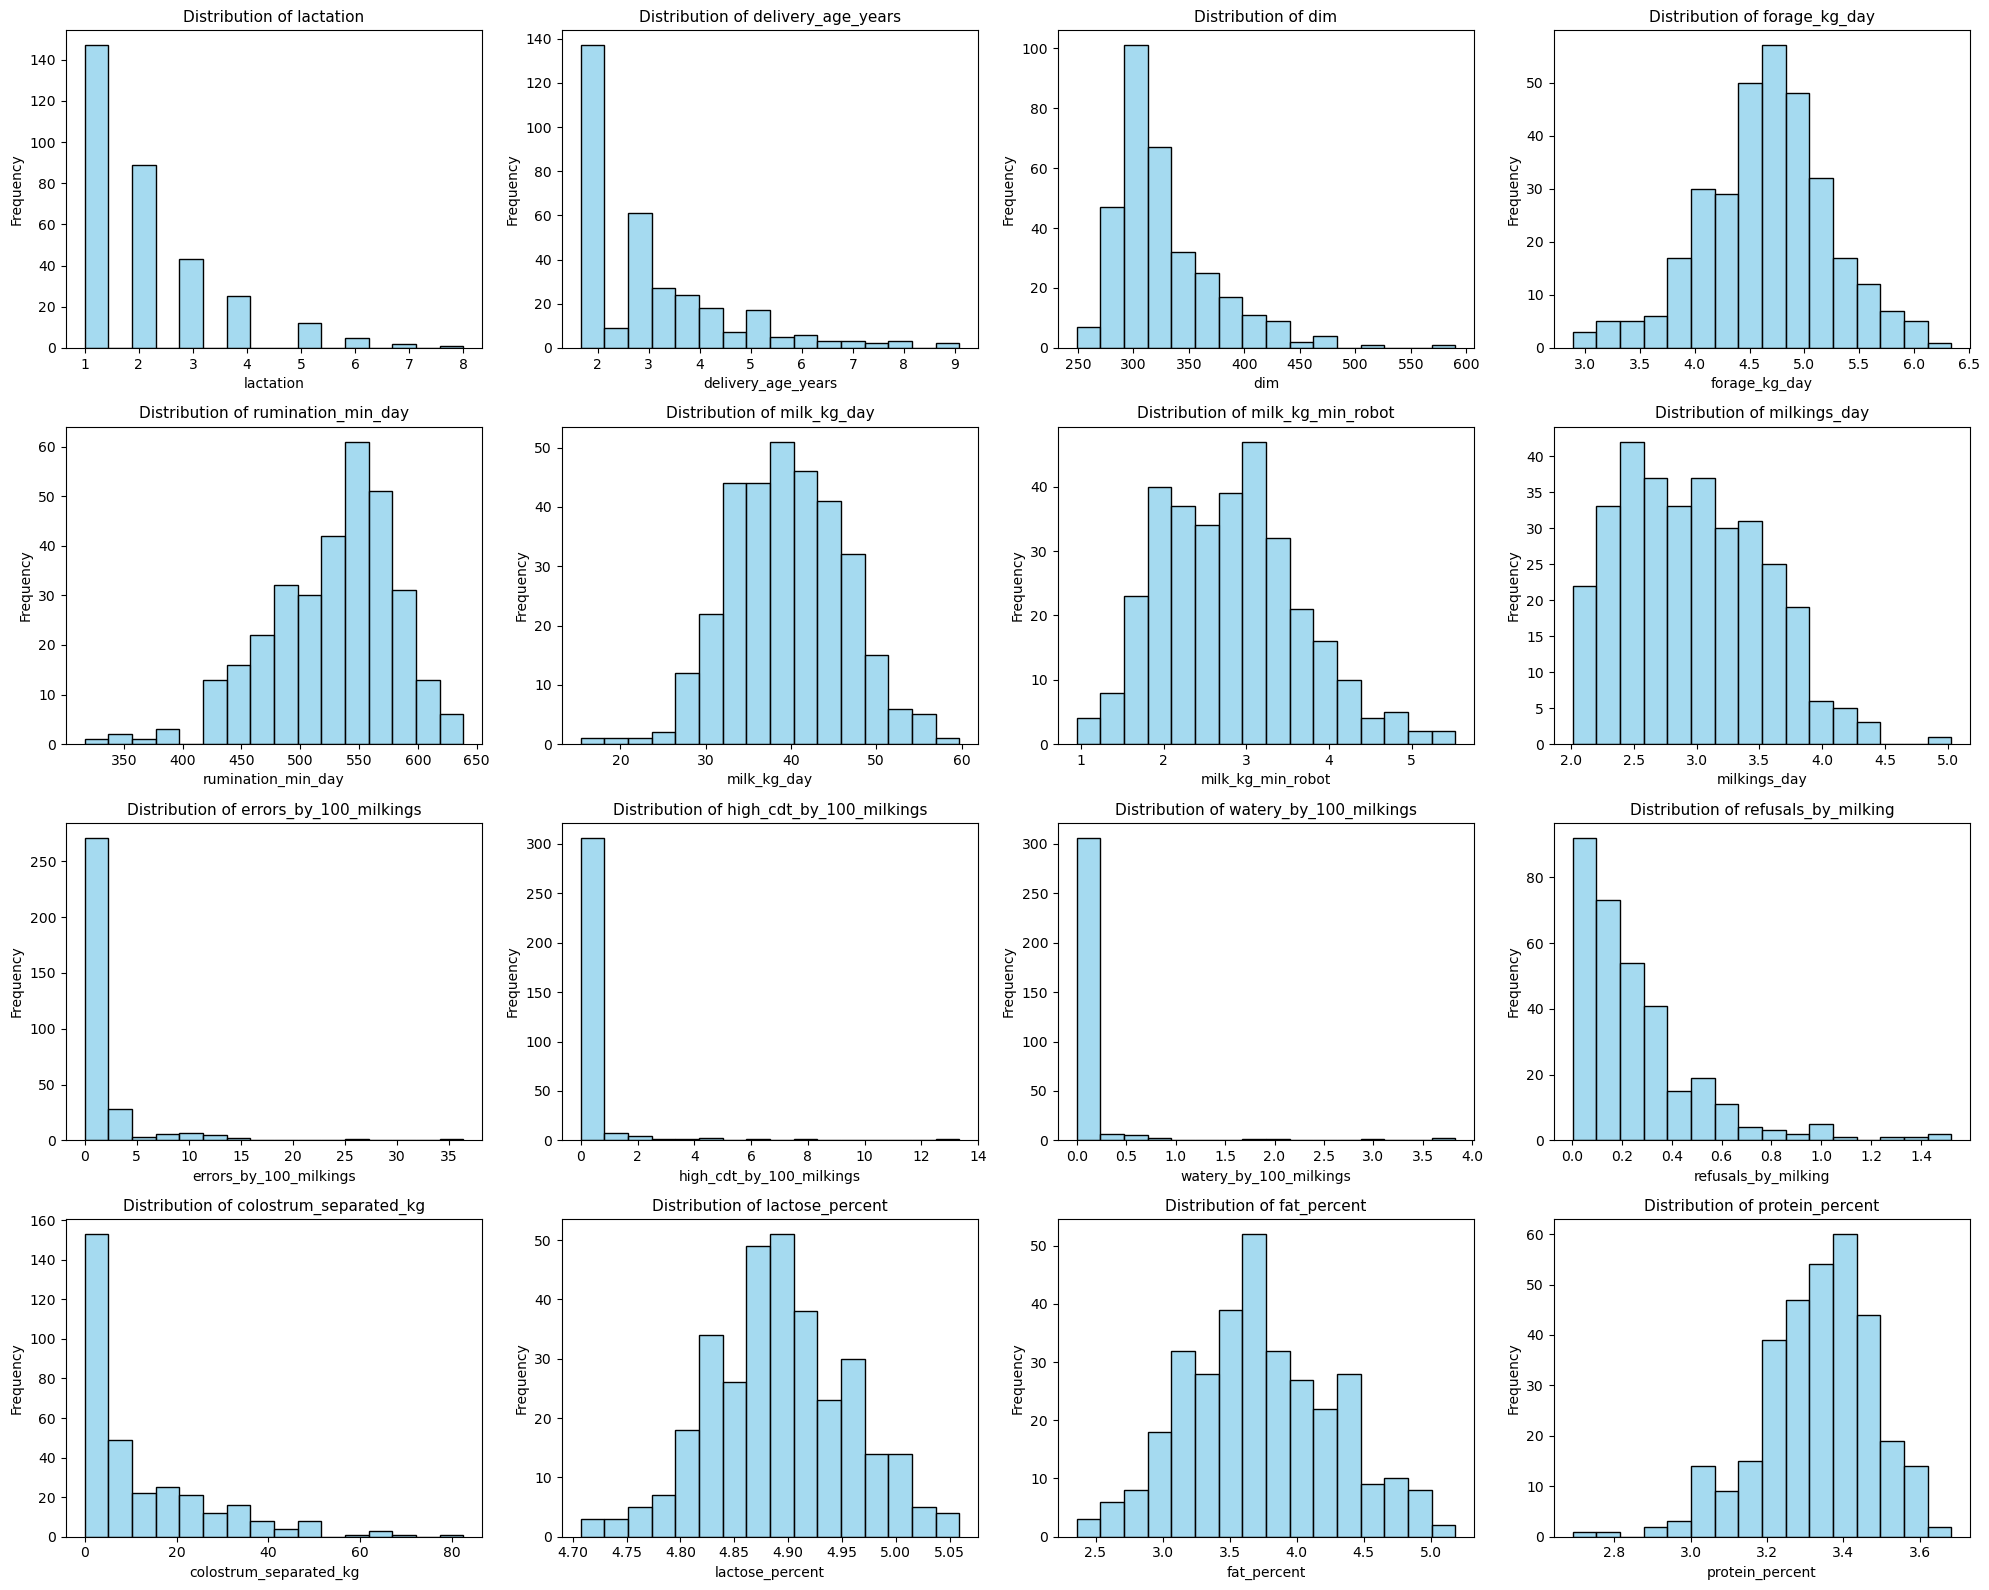

In [15]:
num_columns = len(data.columns)

# Number of rows and columns for subplots
n_rows = 4
n_cols = 4

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 16))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Plot each column
for i, column in enumerate(data.columns):
    sns.histplot(data[column], bins=16, kde=False, color='skyblue', ax=axes[i], edgecolor='black')
    axes[i].set_title(f'Distribution of {column}', fontsize=11)
    axes[i].set_xlabel(column)
    axes[i].set_ylabel('Frequency')

# Remove any unused subplots
for j in range(i+1, n_rows*n_cols):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [16]:
#lactation is categorical so we did one hot encoding here
data = pd.get_dummies(data, columns=['lactation'])
data.iloc[:, -7:] = data.iloc[:, -7:].astype(int)

/var/folders/rk/jdn7ny3s5pz59wz4cb1y33q40000gn/T/ipykernel_27402/239395984.py:3: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0      0
1      0
2      0
3      0
4      0
      ..
319    0
320    0
321    0
322    0
323    0
Name: lactation_2, Length: 324, dtype: int64' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  data.iloc[:, -7:] = data.iloc[:, -7:].astype(int)
/var/folders/rk/jdn7ny3s5pz59wz4cb1y33q40000gn/T/ipykernel_27402/239395984.py:3: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0      0
1      0
2      0
3      0
4      0
      ..
319    0
320    0
321    0
322    0
323    0
Name: lactation_3, Length: 324, dtype: int64' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  data.iloc[:, -7:] = data.iloc[:, -7:].astype(int)
/var/folders/rk/jdn7ny3s5pz59wz4cb1y

In [17]:
data.head()

,delivery_age_years,dim,forage_kg_day,rumination_min_day,milk_kg_day,milk_kg_min_robot,milkings_day,errors_by_100_milkings,high_cdt_by_100_milkings,watery_by_100_milkings,...,fat_percent,protein_percent,lactation_1,lactation_2,lactation_3,lactation_4,lactation_5,lactation_6,lactation_7,lactation_8
0,7.750000,414,4.310918,434.814010,34.082367,3.695699,2.478261,2.046784,0.0,0.000000,...,3.787156,3.511685,False,0,0,0,0,0,1,0
1,9.083333,357,4.167087,589.500000,36.170868,4.024165,2.176471,0.900901,0.0,0.000000,...,3.645519,3.470806,False,0,0,0,0,0,0,1
2,7.666667,315,4.903333,542.577778,43.371746,2.715252,2.387302,1.063830,0.0,0.132979,...,3.458251,3.370124,False,0,0,0,0,1,0,0
3,8.666667,362,4.294724,628.371901,41.683149,2.733291,2.193370,1.763224,0.0,0.000000,...,3.407140,3.221164,False,0,0,0,0,0,1,0
4,6.500000,427,4.798618,479.334112,37.916393,1.888608,3.142857,0.745156,0.0,0.000000,...,4.902554,3.395152,False,0,0,0,1,0,0,0


In [18]:
spearman_corr_matrix = data.corr(method='spearman')

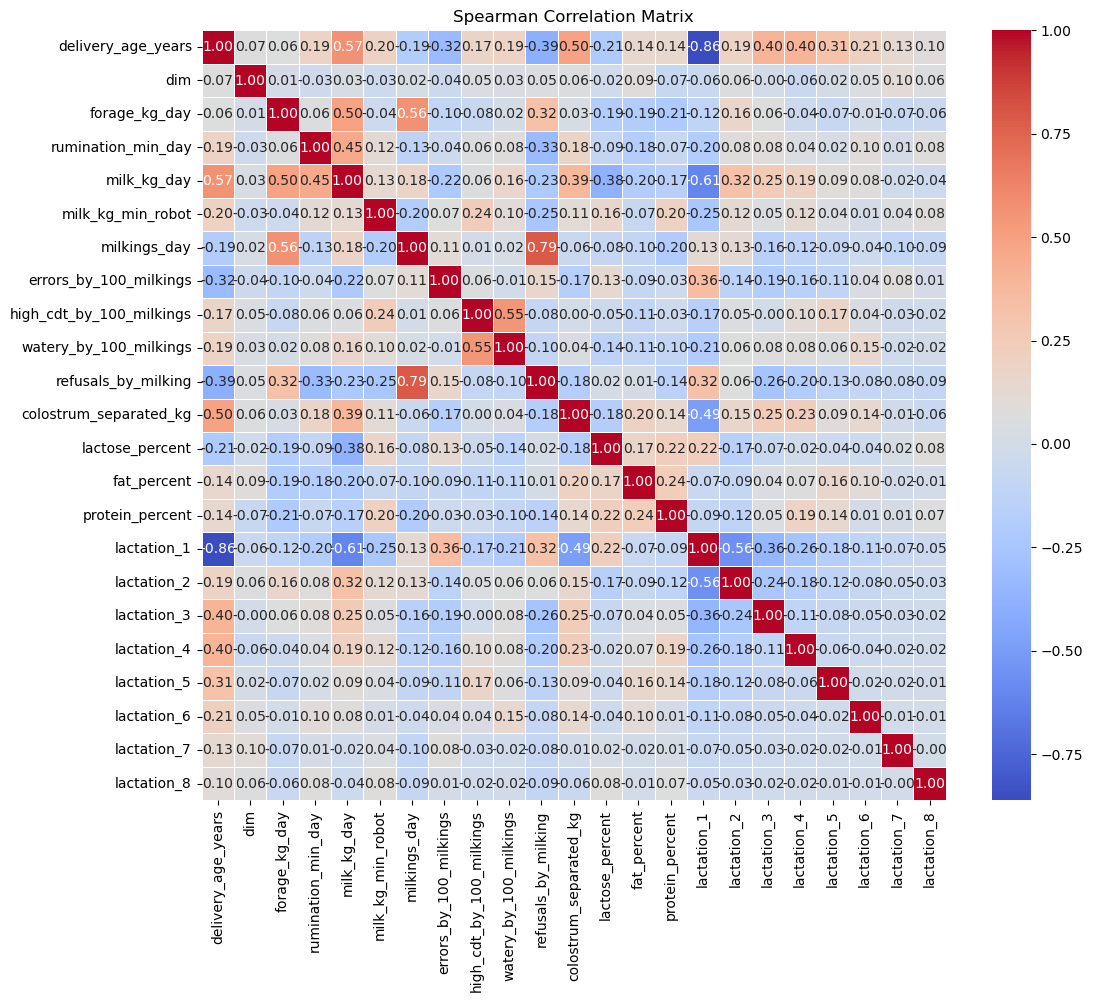

In [19]:
plt.figure(figsize=(12, 10))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(spearman_corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', linewidths=.5)

# Add title
plt.title('Spearman Correlation Matrix')
plt.show()

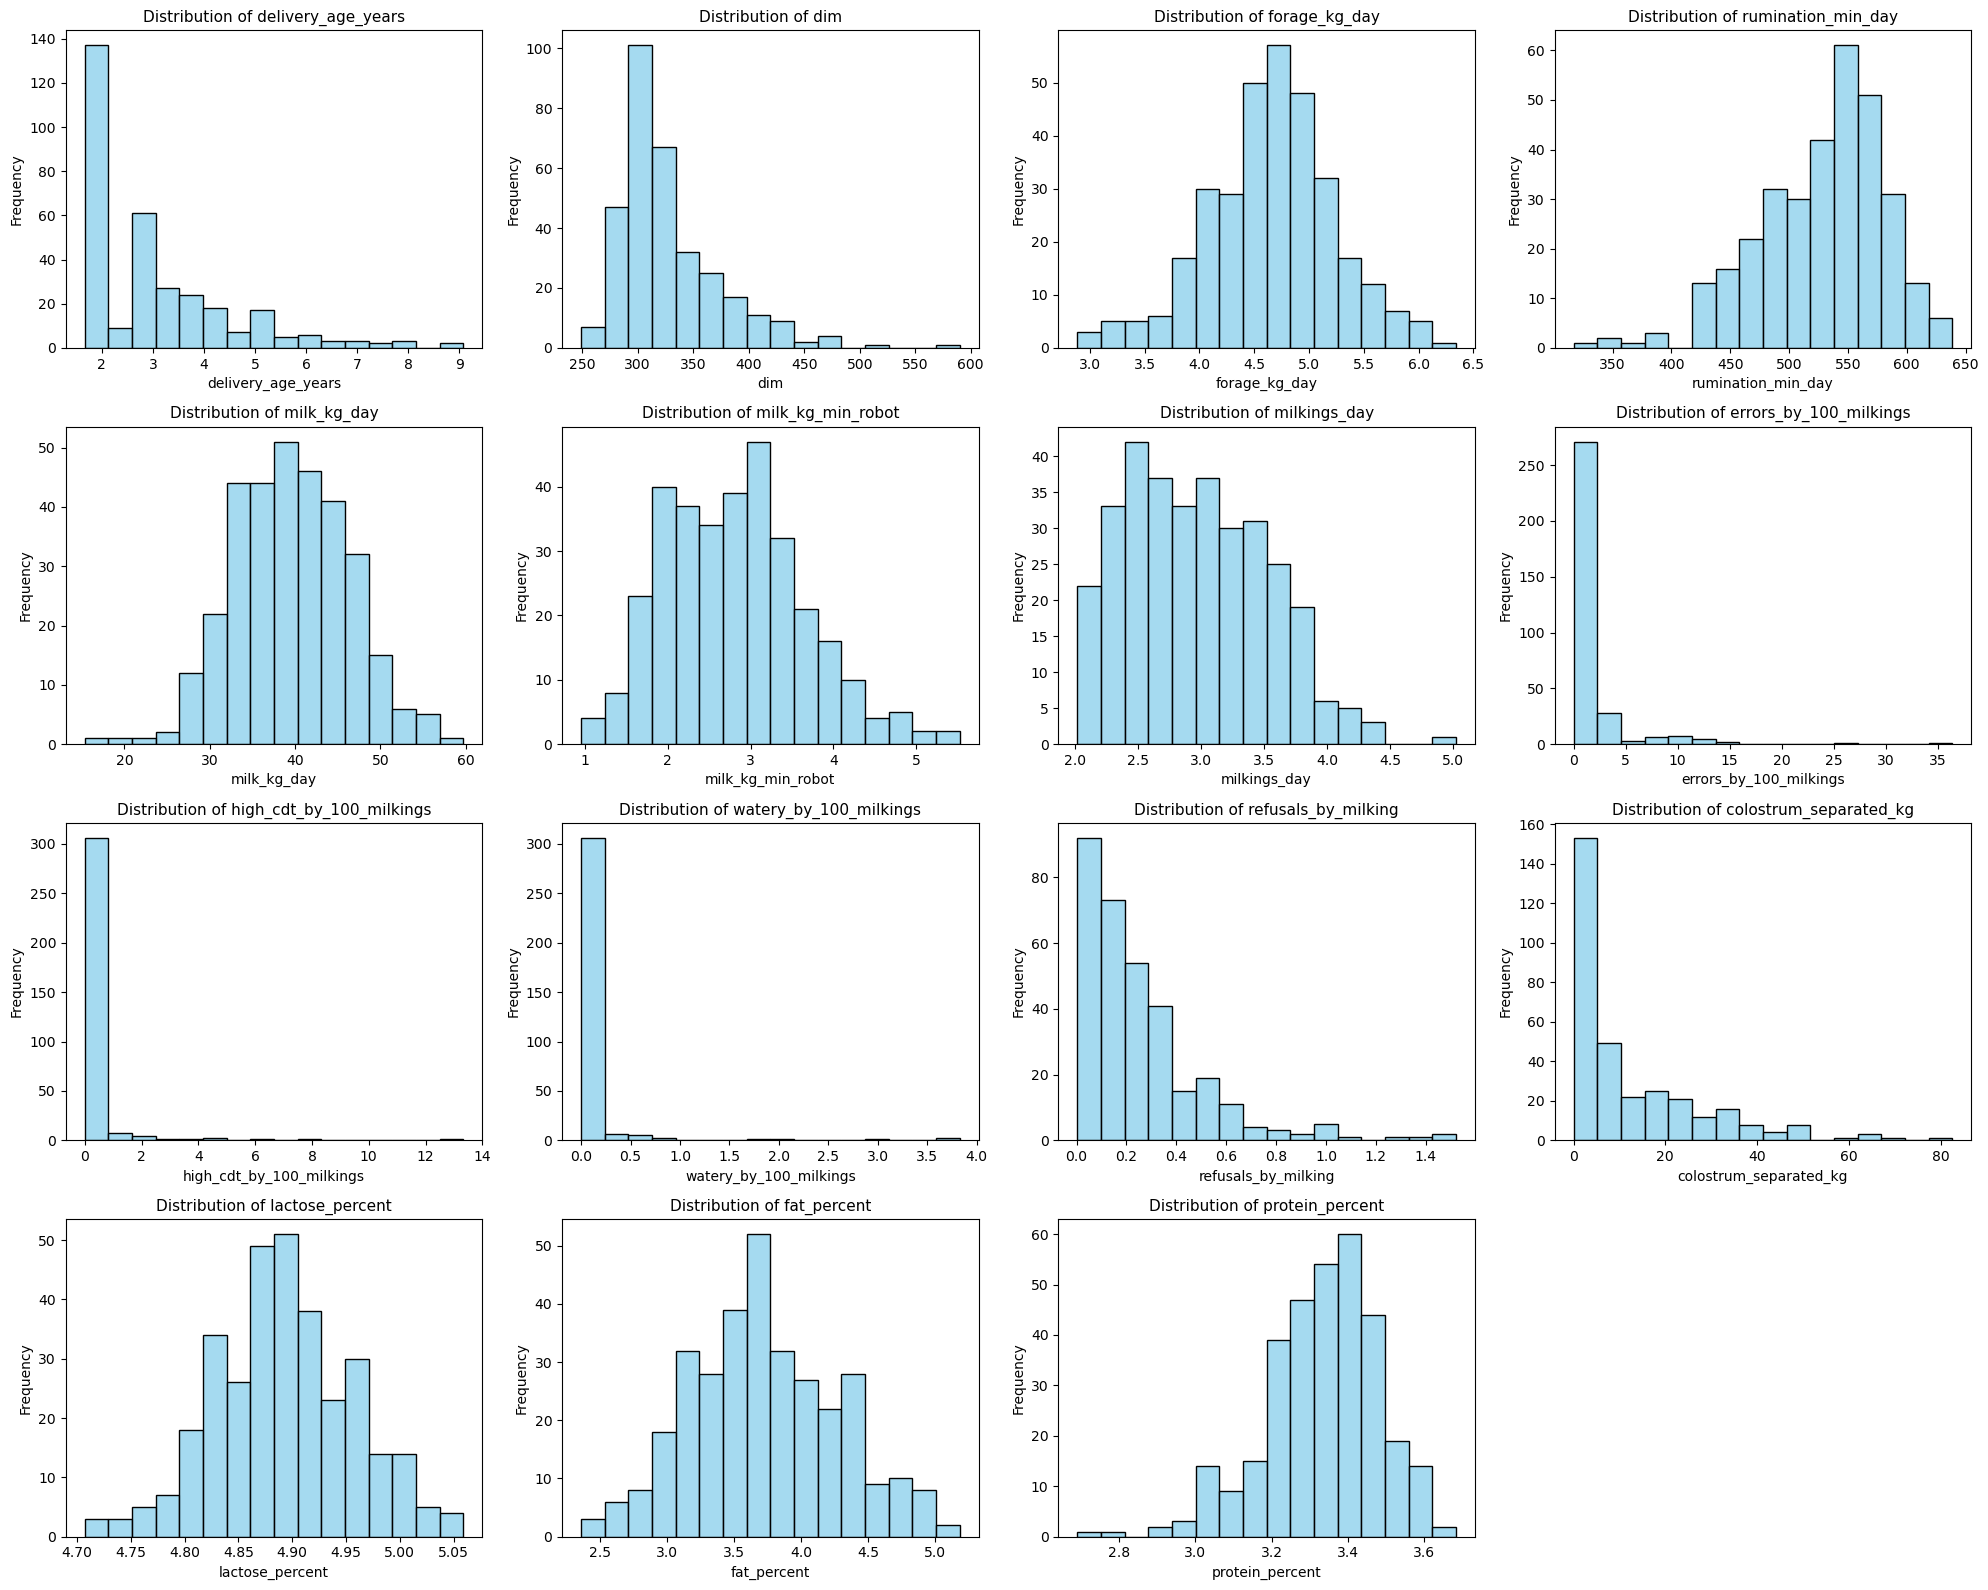

In [20]:
columns_to_plot = [col for col in data.columns if not col.startswith('lactation_')]

num_columns = len(columns_to_plot)

n_rows = 4
n_cols = 4

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 16))

axes = axes.flatten()

for i, column in enumerate(columns_to_plot):
    sns.histplot(data[column], bins=16, kde=False, color='skyblue', ax=axes[i], edgecolor='black')
    axes[i].set_title(f'Distribution of {column}', fontsize=11)
    axes[i].set_xlabel(column)
    axes[i].set_ylabel('Frequency')

for j in range(i+1, n_rows*n_cols):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [21]:
X = data.drop(columns=["fat_percent", "lactose_percent", "protein_percent"])
y_fat = data["fat_percent"]
y_lactose = data["lactose_percent"]
y_protein = data["protein_percent"]

In [22]:
k = 5  
kf = KFold(n_splits=k, shuffle=True, random_state=42)

scaler = StandardScaler()

X_train_kf, X_val_kf = [], []
y_fat_train_kf, y_fat_val_kf = [], []
y_lactose_train_kf, y_lactose_val_kf = [], []
y_protein_train_kf, y_protein_val_kf = [], []

for train_index, val_index in kf.split(X):
    X_train_fold, X_val_fold = X.iloc[train_index], X.iloc[val_index]
    y_fat_train_fold, y_fat_val_fold = y_fat.iloc[train_index], y_fat.iloc[val_index]
    y_lactose_train_fold, y_lactose_val_fold = y_lactose.iloc[train_index], y_lactose.iloc[val_index]
    y_protein_train_fold, y_protein_val_fold = y_protein.iloc[train_index], y_protein.iloc[val_index]

    # Scaler
    X_train_fold_scaled = scaler.fit_transform(X_train_fold)
    X_val_fold_scaled = scaler.transform(X_val_fold)

    # Convert to PyTorch tensors
    X_train_fold_tensor = torch.tensor(X_train_fold_scaled, dtype=torch.float32)
    X_val_fold_tensor = torch.tensor(X_val_fold_scaled, dtype=torch.float32)
    y_fat_train_fold_tensor = torch.tensor(y_fat_train_fold.to_numpy(), dtype=torch.float32).view(-1, 1)
    y_fat_val_fold_tensor = torch.tensor(y_fat_val_fold.to_numpy(), dtype=torch.float32).view(-1, 1)
    y_lactose_train_fold_tensor = torch.tensor(y_lactose_train_fold.to_numpy(), dtype=torch.float32).view(-1, 1)
    y_lactose_val_fold_tensor = torch.tensor(y_lactose_val_fold.to_numpy(), dtype=torch.float32).view(-1, 1)
    y_protein_train_fold_tensor = torch.tensor(y_protein_train_fold.to_numpy(), dtype=torch.float32).view(-1, 1)
    y_protein_val_fold_tensor = torch.tensor(y_protein_val_fold.to_numpy(), dtype=torch.float32).view(-1, 1)

    # Append to lists
    X_train_kf.append(X_train_fold_tensor)
    X_val_kf.append(X_val_fold_tensor)
    y_fat_train_kf.append(y_fat_train_fold_tensor)
    y_fat_val_kf.append(y_fat_val_fold_tensor)
    y_lactose_train_kf.append(y_lactose_train_fold_tensor)
    y_lactose_val_kf.append(y_lactose_val_fold_tensor)
    y_protein_train_kf.append(y_protein_train_fold_tensor)
    y_protein_val_kf.append(y_protein_val_fold_tensor)

# NEURAL NETWORK

In [23]:
def dataloaders(X_train_kf, X_val_kf, y_train_kf, y_val_kf, batch_sizes):
    train_data = []
    val_data = []

    for i in range(len(X_train_kf)):
        train_ds = TensorDataset(X_train_kf[i], y_train_kf[i])
        val_ds = TensorDataset(X_val_kf[i], y_val_kf[i])

        batch_size_GD = batch_sizes['GD']
        batch_size_SGD = batch_sizes['SGD']
        batch_size_MiniSGD = batch_sizes['MiniSGD']
        batch_size_ASGD = batch_sizes['ASGD']
        batch_size_RMSprop = batch_sizes['RMSprop']

        train_dl_GD = DataLoader(train_ds, batch_size_GD, shuffle=True)
        val_dl_GD = DataLoader(val_ds, batch_size_GD, shuffle=True)
        train_dl_SGD = DataLoader(train_ds, batch_size_SGD, shuffle=True)
        val_dl_SGD = DataLoader(val_ds, batch_size_SGD, shuffle=True)
        train_dl_MiniSGD = DataLoader(train_ds, batch_size_MiniSGD, shuffle=True)
        val_dl_MiniSGD = DataLoader(val_ds, batch_size_MiniSGD, shuffle=True)
        train_dl_ASGD = DataLoader(train_ds, batch_size_ASGD, shuffle=True)
        val_dl_ASGD = DataLoader(val_ds, batch_size_ASGD, shuffle=True)
        train_dl_RMSprop = DataLoader(train_ds, batch_size_RMSprop, shuffle=True)
        val_dl_RMSprop = DataLoader(val_ds, batch_size_RMSprop, shuffle=True)
        
        train_data.append({
            'GD': train_dl_GD,
            'SGD': train_dl_SGD,
            'MiniSGD': train_dl_MiniSGD,
            'ASGD': train_dl_ASGD,
            'RMSprop': train_dl_RMSprop
        })

        val_data.append({
            'GD': val_dl_GD,
            'SGD': val_dl_SGD,
            'MiniSGD': val_dl_MiniSGD,
            'ASGD': val_dl_ASGD,
            'RMSprop': val_dl_RMSprop
        })

    return train_data, val_data

# Define batch sizes for each optimizer
batch_sizes = {
    'GD': X_train_kf[0].shape[0],
    'SGD': 1,
    'MiniSGD': 32,
    'ASGD': 64,
    'RMSprop': 128
}

# Get dataloaders for each percentage
fat_train_data, fat_val_data = dataloaders(X_train_kf, X_val_kf, y_fat_train_kf, y_fat_val_kf, batch_sizes)
lactose_train_data, lactose_val_data = dataloaders(X_train_kf, X_val_kf, y_lactose_train_kf, y_lactose_val_kf, batch_sizes)
protein_train_data, protein_val_data = dataloaders(X_train_kf, X_val_kf, y_protein_train_kf, y_protein_val_kf, batch_sizes)

In [24]:
class Net(nn.Module):
    def __init__(self, input_dim):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 16)
        self.fc4 = nn.Linear(16, 1)
        self.activation = nn.ReLU()
        self.apply(self._init_weights)
    
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            nn.init.xavier_uniform_(module.weight)
            nn.init.zeros_(module.bias)
    
    def forward(self, x):
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        x = self.activation(self.fc3(x))
        x = torch.sigmoid(self.fc4(x))
        return x

    def train_model(self, num_epochs, loss_fn, optimizer, train_dl, val_dl, train_size, val_size, batch_size):
        self.apply(self._init_weights)
        loss_hist_train = [0] * num_epochs
        rmse_hist_train = [0] * num_epochs
        loss_hist_valid = [0] * num_epochs
        rmse_hist_valid = [0] * num_epochs

        for epoch in tqdm(range(num_epochs)):
            epoch_train_loss = 0
            train_predictions = []
            train_targets = []
            self.train()
            for x_batch, y_batch in train_dl:
                pred = self(x_batch)
                loss = loss_fn(pred, y_batch)
                loss.backward()
                optimizer.step()
                optimizer.zero_grad()
                epoch_train_loss += loss.item()
                train_predictions.append(pred.detach().cpu().numpy())
                train_targets.append(y_batch.detach().cpu().numpy())

            train_predictions = np.concatenate(train_predictions)
            train_targets = np.concatenate(train_targets)
            loss_hist_train[epoch] = epoch_train_loss / (train_size / batch_size)
            rmse_hist_train[epoch] = compute_rmse(train_predictions, train_targets)

            self.eval()
            with torch.no_grad():
                val_predictions = []
                val_targets = []
                for x_batch, y_batch in val_dl:
                    pred = self(x_batch)
                    val_predictions.append(pred.detach().cpu().numpy())
                    val_targets.append(y_batch.detach().cpu().numpy())

                val_predictions = np.concatenate(val_predictions)
                val_targets = np.concatenate(val_targets)
                valid_loss = loss_fn(torch.tensor(val_predictions), torch.tensor(val_targets)).item()
                loss_hist_valid[epoch] = valid_loss
                rmse_hist_valid[epoch] = compute_rmse(val_predictions, val_targets)

        return loss_hist_train, loss_hist_valid, rmse_hist_train, rmse_hist_valid


# Function to compute RMSE
def compute_rmse(predictions, targets):
    return np.sqrt(np.mean((predictions - targets) ** 2))

def train_and_evaluate_kfold(model, optimizer, num_epochs, loss_fn, X_kf, y_kf):
    history = {}

    for fold_idx, ((X_train_fold, X_val_fold), (y_train_fold, y_val_fold)) in enumerate(zip(X_kf, y_kf)):
        print(f"Training models for fold {fold_idx + 1}...")
        train_ds = TensorDataset(X_train_fold, y_train_fold)
        val_ds = TensorDataset(X_val_fold, y_val_fold)

        train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
        val_dl = DataLoader(val_ds, batch_size=batch_size, shuffle=False)

        model_instance = model(input_dim=X_train_fold.shape[1])
        optimizer_instance = optimizer(model_instance.parameters(), lr=learning_rate)

        history_fold = model_instance.train_model(
            num_epochs=num_epochs,
            loss_fn=loss_fn,
            optimizer=optimizer_instance,
            train_dl=train_dl,
            val_dl=val_dl,
            train_size=len(train_dl.dataset),
            val_size=len(val_dl.dataset),
            batch_size=batch_size
        )

        history[f'Fold_{fold_idx + 1}'] = history_fold

    return history

# Instantiate the neural networks for each target variable
input_dim = X_train_fold.shape[1]
nn_names = ['GD', 'SGD', 'MiniSGD', 'ASGD', 'RMSprop']
nn_torch = {k: Net(input_dim) for k in nn_names}

# Define loss function
loss_fn = nn.MSELoss()

# Define learning rates
learning_rates = {
    'GD': 0.05,
    'SGD': 0.05,
    'MiniSGD': 0.05,
    'ASGD': 0.05,
    'RMSprop': 0.05
}

# Define optimizers
optimizers = {
    'GD': torch.optim.SGD,
    'SGD': torch.optim.SGD,
    'MiniSGD': torch.optim.SGD,
    'ASGD': torch.optim.ASGD,
    'RMSprop': torch.optim.RMSprop
}
num_epochs = 20

In [25]:
def prepare_kfold_data(X, y, k):
    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    scaler = StandardScaler()

    X_kf, y_kf = [], []
    for train_index, val_index in kf.split(X):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]

        X_train_scaled = scaler.fit_transform(X_train)
        X_val_scaled = scaler.transform(X_val)

        X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
        X_val_tensor = torch.tensor(X_val_scaled, dtype=torch.float32)
        y_train_tensor = torch.tensor(y_train.to_numpy(), dtype=torch.float32).view(-1, 1)
        y_val_tensor = torch.tensor(y_val.to_numpy(), dtype=torch.float32).view(-1, 1)

        X_kf.append((X_train_tensor, X_val_tensor))
        y_kf.append((y_train_tensor, y_val_tensor))

    return X_kf, y_kf

def train_and_evaluate_kfold(models, optimizers, num_epochs, loss_fn, X_kf, y_kf, batch_sizes, learning_rates):
    history = {}

    for nn_name, model in models.items():
        optimizer = optimizers[nn_name]
        history_nn = {}
        for fold_idx, ((X_train_fold, X_val_fold), (y_train_fold, y_val_fold)) in enumerate(zip(X_kf, y_kf)):
            print(f"Training {nn_name} for fold {fold_idx + 1}...")
            train_ds = TensorDataset(X_train_fold, y_train_fold)
            val_ds = TensorDataset(X_val_fold, y_val_fold)

            # Retrieve the batch size for the current optimizer
            batch_size = batch_sizes[nn_name]

            train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
            val_dl = DataLoader(val_ds, batch_size=batch_size, shuffle=False)

            optimizer_instance = optimizer(model.parameters(), lr=learning_rates[nn_name])

            history_fold = model.train_model(
                num_epochs=num_epochs,
                loss_fn=loss_fn,
                optimizer=optimizer_instance,
                train_dl=train_dl,
                val_dl=val_dl,
                train_size=len(train_dl.dataset),
                val_size=len(val_dl.dataset),
                batch_size=batch_size  # Use the retrieved batch size
            )

            print(f"Fold {fold_idx + 1} history for {nn_name}: {history_fold}")  # Debug print

            history_nn[f'Fold_{fold_idx + 1}'] = history_fold

        history[nn_name] = history_nn

    return history

def compute_average_history(history):
    avg_history = {}

    for nn_name, folds_history in history.items():
        # Assuming each fold contains a list of tuples (train_loss, val_loss, additional_metrics...)
        first_fold_metrics = folds_history[list(folds_history.keys())[0]]
        num_metrics = len(first_fold_metrics)  # Determine the number of metrics
        
        # Initialize avg_history_nn with the appropriate keys
        avg_history_nn = {f'metric_{i}': [] for i in range(num_metrics)}

        for fold_name, metrics in folds_history.items():
            #print(f"Fold {fold_name} metrics for {nn_name}: {metrics}")  # Debug print

            for i, values in enumerate(metrics):
                key = f'metric_{i}'
                for epoch in range(len(values)):
                    if len(avg_history_nn[key]) <= epoch:
                        avg_history_nn[key].append(0)
                    avg_history_nn[key][epoch] += values[epoch]

        num_folds = len(folds_history)
        for key in avg_history_nn:
            avg_history_nn[key] = [value / num_folds for value in avg_history_nn[key]]
        
        avg_history[nn_name] = avg_history_nn

    return avg_history

# Assuming batch_sizes and learning_rates are dictionaries mapping model names to their corresponding values
X_fat_kf, y_fat_kf = prepare_kfold_data(X, y_fat, k)
X_lactose_kf, y_lactose_kf = prepare_kfold_data(X, y_lactose, k)
X_protein_kf, y_protein_kf = prepare_kfold_data(X, y_protein, k)

# Call the function with the appropriate parameters
history_kfold_fat = train_and_evaluate_kfold(nn_torch, optimizers, num_epochs, loss_fn, X_fat_kf, y_fat_kf, batch_sizes, learning_rates)
history_kfold_lactose = train_and_evaluate_kfold(nn_torch, optimizers, num_epochs, loss_fn, X_lactose_kf, y_lactose_kf, batch_sizes, learning_rates)
history_kfold_protein = train_and_evaluate_kfold(nn_torch, optimizers, num_epochs, loss_fn, X_protein_kf, y_protein_kf, batch_sizes, learning_rates)

# Compute average histories
avg_history_fat = compute_average_history(history_kfold_fat)
avg_history_lactose = compute_average_history(history_kfold_lactose)
avg_history_protein = compute_average_history(history_kfold_protein)



Training GD for fold 1...


100%|██████████| 20/20 [00:00<00:00, 179.63it/s]


Fold 1 history for GD: ([10.525671005249023, 9.966760635375977, 9.479342460632324, 9.048666954040527, 8.694177627563477, 8.42576789855957, 8.239642143249512, 8.116074562072754, 8.033732414245605, 7.977331638336182, 7.937448978424072, 7.908405780792236, 7.886618137359619, 7.869805812835693, 7.856565952301025, 7.84594202041626, 7.837277412414551, 7.8301100730896, 7.824099540710449, 7.818999767303467], [9.834912300109863, 9.31912899017334, 8.866097450256348, 8.498393058776855, 8.226349830627441, 8.044187545776367, 7.926846027374268, 7.849809169769287, 7.797684192657471, 7.761031627655029, 7.734563827514648, 7.714844703674316, 7.699733257293701, 7.6879048347473145, 7.678446292877197, 7.670763969421387, 7.664432048797607, 7.659145832061768, 7.654677391052246, 7.650861740112305], [3.244329, 3.1570175, 3.0788538, 3.0081, 2.948589, 2.9027174, 2.8704777, 2.8488724, 2.834384, 2.8244169, 2.8173478, 2.8121889, 2.8083122, 2.8053174, 2.8029566, 2.801061, 2.7995138, 2.7982333, 2.7971592, 2.7962475], 

100%|██████████| 20/20 [00:00<00:00, 255.94it/s]


Fold 2 history for GD: ([10.30273151397705, 9.638166427612305, 9.070448875427246, 8.624859809875488, 8.3110990524292, 8.10495376586914, 7.972638130187988, 7.8863139152526855, 7.828085422515869, 7.78721284866333, 7.757580280303955, 7.735406398773193, 7.718322277069092, 7.704916000366211, 7.694188594818115, 7.685445308685303, 7.678215980529785, 7.67214822769165, 7.6670122146606445, 7.662616729736328], [10.355566024780273, 9.746551513671875, 9.273870468139648, 8.944114685058594, 8.728830337524414, 8.591007232666016, 8.501075744628906, 8.440281867980957, 8.39754581451416, 8.36646842956543, 8.343195915222168, 8.325237274169922, 8.311149597167969, 8.299872398376465, 8.290674209594727, 8.283060073852539, 8.276668548583984, 8.271255493164062, 8.266617774963379, 8.262606620788574], [3.209787, 3.1045396, 3.0117185, 2.9368112, 2.8828976, 2.84692, 2.8235862, 2.808258, 2.7978716, 2.7905579, 2.7852433, 2.7812598, 2.7781868, 2.775773, 2.77384, 2.7722638, 2.7709591, 2.7698643, 2.768937, 2.7681432], [3

100%|██████████| 20/20 [00:00<00:00, 270.85it/s]


Fold 3 history for GD: ([10.123645782470703, 9.501507759094238, 8.971063613891602, 8.571441650390625, 8.302644729614258, 8.132328987121582, 8.023940086364746, 7.953268051147461, 7.905478477478027, 7.872005462646484, 7.847731113433838, 7.8295512199401855, 7.815514087677002, 7.804443836212158, 7.795537948608398, 7.788254737854004, 7.782212257385254, 7.777135848999023, 7.772824764251709, 7.769121170043945], [9.508484840393066, 8.989314079284668, 8.596748352050781, 8.333114624023438, 8.165596008300781, 8.05933952331543, 7.9898176193237305, 7.942966938018799, 7.910144805908203, 7.886358261108398, 7.868565082550049, 7.854833126068115, 7.843992233276367, 7.835269451141357, 7.828117370605469, 7.822178363800049, 7.817183017730713, 7.81293249130249, 7.809277534484863, 7.8061065673828125], [3.1817675, 3.0824516, 2.9951735, 2.9277024, 2.8814309, 2.851724, 2.832656, 2.8201542, 2.8116684, 2.8057094, 2.8013802, 2.7981336, 2.795624, 2.7936435, 2.7920492, 2.7907445, 2.7896616, 2.7887518, 2.7879786, 2.7

100%|██████████| 20/20 [00:00<00:00, 271.49it/s]


Fold 4 history for GD: ([10.963068008422852, 10.349996566772461, 9.813263893127441, 9.34239673614502, 8.929655075073242, 8.59278392791748, 8.342792510986328, 8.170263290405273, 8.053542137145996, 7.974146366119385, 7.919012069702148, 7.879425525665283, 7.850252151489258, 7.8281636238098145, 7.811051845550537, 7.797515869140625, 7.786611557006836, 7.777698993682861, 7.77030611038208, 7.764096260070801], [10.50472640991211, 9.966836929321289, 9.50473403930664, 9.099180221557617, 8.766559600830078, 8.51773452758789, 8.343605995178223, 8.224533081054688, 8.14261531829834, 8.08531665802002, 8.043972969055176, 8.013307571411133, 7.989944934844971, 7.971771717071533, 7.957337379455566, 7.945659160614014, 7.936075687408447, 7.928105354309082, 7.921385765075684, 7.915666103363037], [3.311052, 3.2171412, 3.132613, 3.0565336, 2.988253, 2.9313452, 2.8883893, 2.8583672, 2.8378763, 2.823853, 2.814074, 2.8070316, 2.80183, 2.7978857, 2.794826, 2.7924032, 2.7904499, 2.7888525, 2.7875266, 2.7864127], [3

100%|██████████| 20/20 [00:00<00:00, 229.76it/s]


Fold 5 history for GD: ([15.067624453397897, 20.985344560329732, 21.233609716708845, 14.933932436429536, 16.173764808361348, 9.932610649787463, 18.236206718591543, 19.298337554931642, 13.961250396875235, 19.22403803421901, 16.201314992171067, 18.121834505521335, 12.905898330761836, 18.1139575279676, 15.324665293326746, 15.628505345491263, 19.097158037699185, 20.620758252877454, 12.957949653038613, 14.768522082842313], [9.092123031616211, 8.244515419006348, 7.769372463226318, 7.603839874267578, 7.464544773101807, 7.419743537902832, 7.3886518478393555, 7.345795631408691, 7.3280439376831055, 7.309351921081543, 7.292844772338867, 7.284911155700684, 7.278432369232178, 7.267744064331055, 7.2603349685668945, 7.2577314376831055, 7.253287315368652, 7.251447677612305, 7.247692584991455, 7.245510101318359], [3.2361248, 3.1267323, 2.9806476, 2.8970587, 2.868016, 2.8436034, 2.8361218, 2.8309214, 2.82401, 2.821034, 2.8180094, 2.8153534, 2.8140845, 2.8130457, 2.8114405, 2.810299, 2.8098762, 2.8091776

100%|██████████| 20/20 [00:00<00:00, 24.18it/s]


Fold 1 history for SGD: ([7.81713219453009, 7.767562526073235, 7.767201970903109, 7.76706879019277, 7.767000187317837, 7.766958690978385, 7.76693120011952, 7.766911645653625, 7.766897068981038, 7.766885872513171, 7.766877033995845, 7.76686983357065, 7.766863902103027, 7.766858823511131, 7.766854551307944, 7.766850899545382, 7.76684769470259, 7.76684490271977, 7.766842377231848, 7.766840222719553], [7.611916542053223, 7.610978126525879, 7.61070442199707, 7.610579967498779, 7.610508441925049, 7.610463619232178, 7.6104326248168945, 7.610409736633301, 7.610393047332764, 7.610379695892334, 7.610368251800537, 7.610360145568848, 7.610352039337158, 7.610346794128418, 7.6103410720825195, 7.610336780548096, 7.61033296585083, 7.6103291511535645, 7.610326766967773, 7.610324382781982], [2.7959135, 2.7870347, 2.7869701, 2.786946, 2.786934, 2.7869265, 2.7869215, 2.786918, 2.7869153, 2.7869134, 2.7869117, 2.7869105, 2.7869093, 2.7869086, 2.7869077, 2.786907, 2.7869065, 2.786906, 2.7869055, 2.786905], 

100%|██████████| 20/20 [00:00<00:00, 23.08it/s]


Fold 2 history for SGD: ([7.6641470410188655, 7.615498534500829, 7.615178168050111, 7.615058209905293, 7.614996078391793, 7.614958460726793, 7.614933272126098, 7.614915380146512, 7.614902042053841, 7.614891701683574, 7.614883405361397, 7.61487686219823, 7.6148712994048955, 7.614866685222935, 7.614862706210162, 7.614859281359492, 7.614856241752743, 7.614853767814783, 7.6148514195298596, 7.614849492849991], [8.217004776000977, 8.216400146484375, 8.216214179992676, 8.216126441955566, 8.21607494354248, 8.21604061126709, 8.216018676757812, 8.216001510620117, 8.215988159179688, 8.215977668762207, 8.215970039367676, 8.215963363647461, 8.215957641601562, 8.21595287322998, 8.215948104858398, 8.215944290161133, 8.215941429138184, 8.215938568115234, 8.215936660766602, 8.215933799743652], [2.7684195, 2.7596192, 2.7595613, 2.7595394, 2.7595282, 2.7595215, 2.7595167, 2.7595136, 2.7595112, 2.7595093, 2.759508, 2.7595067, 2.7595057, 2.7595048, 2.759504, 2.7595034, 2.759503, 2.7595024, 2.759502, 2.7595

100%|██████████| 20/20 [00:00<00:00, 23.87it/s]


Fold 3 history for SGD: ([7.805484062916523, 7.728231066902632, 7.727836456538167, 7.727692186602294, 7.727618491787708, 7.727574070448121, 7.727544651068316, 7.727523693246731, 7.727508104906119, 7.727496155440577, 7.727486626982229, 7.727478893567236, 7.727472575014622, 7.727467252480937, 7.72746264336192, 7.727458821300374, 7.727455436492979, 7.727452449356727, 7.72744988382553, 7.727447478467433], [7.768430233001709, 7.767762184143066, 7.76756477355957, 7.767475128173828, 7.767423152923584, 7.767391204833984, 7.767367839813232, 7.767350673675537, 7.767338275909424, 7.76732873916626, 7.76732063293457, 7.767314434051514, 7.767308712005615, 7.767303943634033, 7.767299175262451, 7.767296314239502, 7.767294406890869, 7.767291069030762, 7.767289161682129, 7.767286777496338], [2.7938297, 2.7799697, 2.7798986, 2.7798727, 2.7798595, 2.7798514, 2.7798462, 2.7798424, 2.7798395, 2.7798374, 2.7798357, 2.7798343, 2.7798333, 2.7798324, 2.7798314, 2.7798307, 2.77983, 2.7798295, 2.779829, 2.7798288

100%|██████████| 20/20 [00:00<00:00, 24.39it/s]


Fold 4 history for SGD: ([7.76404518510384, 7.706084378437646, 7.70570923232664, 7.705568888933042, 7.705496044232579, 7.705451955206145, 7.705422493481728, 7.7054016649953185, 7.705386046737317, 7.705374023628972, 7.7053645186442665, 7.705356708824865, 7.705350271983496, 7.705344931959646, 7.705340377152196, 7.705336398139424, 7.705332974209289, 7.705329931840933, 7.705327277478104, 7.705324940239601], [7.856238842010498, 7.855769157409668, 7.8556294441223145, 7.855564594268799, 7.855526924133301, 7.855503559112549, 7.855488300323486, 7.855475902557373, 7.855466365814209, 7.855459690093994, 7.8554534912109375, 7.85545015335083, 7.8554463386535645, 7.855443000793457, 7.855439186096191, 7.855437278747559, 7.855434894561768, 7.855432987213135, 7.855432033538818, 7.855431079864502], [2.7864037, 2.7759836, 2.7759159, 2.7758906, 2.7758775, 2.7758696, 2.7758644, 2.7758605, 2.7758577, 2.7758555, 2.7758539, 2.7758524, 2.7758512, 2.7758503, 2.7758496, 2.7758489, 2.7758482, 2.7758477, 2.7758472,

100%|██████████| 20/20 [00:00<00:00, 23.76it/s]


Fold 5 history for SGD: ([7.92552868265372, 7.863020882698206, 7.86263028887602, 7.862487637538177, 7.862414859808409, 7.862370994457832, 7.862341812482247, 7.862321219535974, 7.862305880051393, 7.862294002679678, 7.862284648418426, 7.862277085047502, 7.862270804551931, 7.86226555292423, 7.862261085785352, 7.862257272922076, 7.862253913971094, 7.862250958497707, 7.862248364778665, 7.862246129145989], [7.221395492553711, 7.2207536697387695, 7.220562934875488, 7.220475196838379, 7.220424175262451, 7.220392227172852, 7.220369338989258, 7.220352649688721, 7.220340251922607, 7.220330715179443, 7.220322608947754, 7.2203168869018555, 7.220310688018799, 7.220306396484375, 7.220302104949951, 7.22029972076416, 7.220296382904053, 7.220293045043945, 7.2202911376953125, 7.2202887535095215], [2.8152316, 2.804108, 2.8040383, 2.8040128, 2.804, 2.803992, 2.8039868, 2.8039832, 2.8039804, 2.8039782, 2.8039768, 2.803975, 2.8039742, 2.8039732, 2.8039725, 2.8039715, 2.803971, 2.8039706, 2.80397, 2.8039699],

100%|██████████| 20/20 [00:00<00:00, 428.67it/s]


Fold 1 history for MiniSGD: ([10.047307018147473, 8.56069209861019, 8.707080561221797, 8.275665695602829, 8.368781365943232, 8.522496521703065, 8.231400302017978, 8.461903693593147, 8.415083955153536, 8.654737730283994, 8.64150688731072, 8.518021631424952, 8.62800003110672, 8.655734853854971, 8.772348646951919, 8.408113221864443, 8.486487782599843, 8.74502504562319, 8.753703585002413, 8.497018350137246], [7.765038967132568, 7.655468940734863, 7.634721279144287, 7.626398086547852, 7.6217193603515625, 7.619143009185791, 7.617410182952881, 7.616065979003906, 7.6152496337890625, 7.614602088928223, 7.614055156707764, 7.613658905029297, 7.61332368850708, 7.613057613372803, 7.612824440002441, 7.612629413604736, 7.612462520599365, 7.612310409545898, 7.612174034118652, 7.612057685852051], [2.985705, 2.8041372, 2.7933865, 2.7907293, 2.7895393, 2.7888288, 2.7884214, 2.7881398, 2.787916, 2.7877786, 2.787669, 2.7875748, 2.7875066, 2.7874477, 2.7874012, 2.7873604, 2.7873259, 2.7872965, 2.7872696, 2.

100%|██████████| 20/20 [00:00<00:00, 429.62it/s]


Fold 2 history for MiniSGD: ([11.338710239955358, 9.230446951729911, 8.333553476223154, 8.516728758351682, 8.636417580387308, 8.579207372481298, 8.7190262488877, 8.590143800242068, 8.462114783327552, 8.81745704444679, 8.610285990947002, 8.918984785043135, 8.280727489574536, 8.739284913052003, 8.156174471939853, 8.554040209206835, 8.84921205734194, 8.298904006545609, 8.322966174269276, 8.41403003825184], [9.507023811340332, 8.488677024841309, 8.304868698120117, 8.261091232299805, 8.243945121765137, 8.23572826385498, 8.230957984924316, 8.227764129638672, 8.225783348083496, 8.223967552185059, 8.222819328308105, 8.221970558166504, 8.22132396697998, 8.220768928527832, 8.2203369140625, 8.219965934753418, 8.219644546508789, 8.219367980957031, 8.219124794006348, 8.218908309936523], [3.185757, 2.8899684, 2.7907772, 2.7715616, 2.7661073, 2.763758, 2.7625673, 2.7618575, 2.7613716, 2.7610626, 2.760788, 2.760604, 2.760468, 2.760364, 2.7602758, 2.7602065, 2.760147, 2.7600954, 2.7600505, 2.7600117], 

100%|██████████| 20/20 [00:00<00:00, 425.14it/s]


Fold 3 history for MiniSGD: ([9.853211568589376, 8.40402804930698, 8.440812571168406, 8.425526386982686, 8.66946994383823, 8.743068267940094, 8.328441546230243, 8.704755628431165, 8.82552906168934, 8.685516534164606, 8.791097103398739, 8.833173125867217, 8.741393748397533, 8.570995964138664, 8.478817560497859, 8.419325662855936, 8.552277495041777, 8.521156458320766, 8.710402499754917, 8.450989653244902], [7.889379978179932, 7.809377670288086, 7.792250156402588, 7.784374713897705, 7.7797932624816895, 7.77732515335083, 7.775520324707031, 7.774227619171143, 7.773269176483154, 7.772566795349121, 7.77196741104126, 7.771479606628418, 7.771078586578369, 7.770736217498779, 7.770425796508789, 7.7701568603515625, 7.769960403442383, 7.769779205322266, 7.7696027755737305, 7.769460678100586], [2.94168, 2.793005, 2.7852802, 2.7832685, 2.7822576, 2.7816381, 2.781299, 2.7810445, 2.7808592, 2.780721, 2.780619, 2.780531, 2.7804594, 2.7804008, 2.78035, 2.780305, 2.7802644, 2.7802353, 2.7802076, 2.7801816

100%|██████████| 20/20 [00:00<00:00, 413.44it/s]


Fold 4 history for MiniSGD: ([10.252174053413068, 8.693364912938888, 8.425213905835244, 8.582333951383024, 8.188594626643942, 8.745280203211722, 8.658943087898166, 8.182821266439431, 8.6601133015165, 8.336416001485581, 8.360774036540027, 8.664502825055804, 8.505134435233922, 8.784352895375845, 8.59137858387126, 8.353543314694438, 8.33812056729232, 8.556945034896085, 8.562647874751146, 8.598784104277268], [8.276712417602539, 7.943114280700684, 7.897131443023682, 7.880972862243652, 7.873057842254639, 7.868720054626465, 7.865938663482666, 7.864046573638916, 7.862568378448486, 7.861569404602051, 7.860771179199219, 7.860171794891357, 7.859635353088379, 7.859226703643799, 7.858880996704102, 7.858572483062744, 7.858325958251953, 7.858118534088135, 7.857921600341797, 7.8577561378479], [3.0829887, 2.8148787, 2.7869399, 2.781736, 2.7796574, 2.7785575, 2.7779336, 2.777516, 2.7772274, 2.7769992, 2.7768445, 2.7767181, 2.7766232, 2.7765374, 2.7764719, 2.776416, 2.776366, 2.776326, 2.776292, 2.776259

100%|██████████| 20/20 [00:00<00:00, 385.34it/s]


Fold 5 history for MiniSGD: ([10.422569216214693, 8.745153515155499, 8.794875218318058, 8.754270758995643, 8.784191425030048, 8.676781170184796, 8.803483581542968, 8.643575697678786, 8.750414393498348, 8.508537351168119, 8.746375039907603, 9.147782545823317, 8.848249934269832, 8.62091575035682, 8.622176713209885, 8.79062723013071, 8.699349447397084, 8.699717125525842, 8.466898756760818, 8.97757832453801], [7.51234769821167, 7.286594867706299, 7.251598834991455, 7.239541530609131, 7.2337188720703125, 7.230399131774902, 7.228214740753174, 7.226665496826172, 7.225616455078125, 7.224834442138672, 7.224296569824219, 7.223852157592773, 7.223437786102295, 7.223119258880615, 7.222874164581299, 7.222672462463379, 7.222476959228516, 7.222298622131348, 7.2221574783325195, 7.2220258712768555], [3.0925877, 2.8363364, 2.8144052, 2.8096032, 2.80767, 2.8066485, 2.8060336, 2.8056118, 2.805307, 2.8050957, 2.8049364, 2.8048263, 2.8047338, 2.8046467, 2.80458, 2.8045282, 2.8044853, 2.8044434, 2.8044052, 2.

100%|██████████| 20/20 [00:00<00:00, 431.72it/s]


Fold 1 history for ASGD: ([11.341774958901423, 10.516976610574023, 10.198522147985038, 9.612340743017013, 9.391452391635497, 9.417082561949504, 8.873437122948841, 10.36618371911951, 9.737827492496683, 9.579732769704693, 9.765202349217242, 9.232369323494812, 9.852160126085908, 10.132432149644064, 9.383141948449566, 9.321279989706504, 9.799576689377714, 9.576156675125182, 8.927623144908301, 9.359970387344655], [7.9340057373046875, 7.7087321281433105, 7.659369468688965, 7.639428615570068, 7.630866050720215, 7.626165866851807, 7.622859477996826, 7.620558738708496, 7.619020938873291, 7.617962837219238, 7.617074966430664, 7.6162261962890625, 7.615609169006348, 7.615133285522461, 7.614624500274658, 7.614187717437744, 7.613873481750488, 7.613612651824951, 7.613344192504883, 7.613131999969482], [3.0640168, 2.830753, 2.8032463, 2.795861, 2.7925377, 2.7910292, 2.7901692, 2.7895398, 2.7890944, 2.7887921, 2.7885792, 2.7883978, 2.7882235, 2.788094, 2.787994, 2.7878861, 2.787793, 2.7877254, 2.787669,

100%|██████████| 20/20 [00:00<00:00, 447.89it/s]


Fold 2 history for ASGD: ([10.767543365596344, 9.581514689913128, 9.926104924853703, 10.475997158919522, 9.36818079414515, 9.431687520737814, 10.825079722754284, 9.466532585703728, 10.322412674951737, 10.123158929891108, 9.904342003310509, 9.02054245407517, 9.632674051527811, 9.664081352557915, 9.52700240087325, 9.721401258785292, 8.89775291649071, 9.203692697650217, 9.447856652690637, 9.930871911951014], [8.778656005859375, 8.374452590942383, 8.297731399536133, 8.267861366271973, 8.252626419067383, 8.244657516479492, 8.235963821411133, 8.232629776000977, 8.23021125793457, 8.228517532348633, 8.227129936218262, 8.225956916809082, 8.225107192993164, 8.2243013381958, 8.223549842834473, 8.222919464111328, 8.222380638122559, 8.221953392028809, 8.221571922302246, 8.221261978149414], [3.057929, 2.8241546, 2.7806547, 2.7710392, 2.7669752, 2.7648504, 2.763706, 2.762492, 2.7619946, 2.7616358, 2.761383, 2.7611728, 2.760995, 2.7608676, 2.7607458, 2.7606328, 2.760536, 2.7604537, 2.7603896, 2.760332

100%|██████████| 20/20 [00:00<00:00, 449.11it/s]


Fold 3 history for ASGD: ([11.495333991916024, 9.27454273120777, 9.267027158994932, 9.730529313842302, 9.282020362647804, 9.323338453373854, 9.664313592505732, 9.433110417546454, 9.016679447129887, 10.066711897095198, 9.53261846004766, 9.513881845363779, 9.091762822567265, 9.314701036136583, 9.445307197718087, 9.404482101381516, 9.203089533625421, 9.432328625535412, 9.014008275330298, 10.08721181508657], [8.113715171813965, 7.902541160583496, 7.837975025177002, 7.816656589508057, 7.804208278656006, 7.796714782714844, 7.7917046546936035, 7.788060665130615, 7.784368991851807, 7.782582759857178, 7.780403137207031, 7.779144287109375, 7.778163433074951, 7.7769856452941895, 7.776247024536133, 7.77564001083374, 7.775041103363037, 7.774561405181885, 7.774024963378906, 7.773612022399902], [3.0598416, 2.817574, 2.7955513, 2.7882464, 2.7857277, 2.7842405, 2.7833276, 2.782718, 2.7822723, 2.7818294, 2.7816107, 2.7813509, 2.7811983, 2.7810783, 2.7809374, 2.7808495, 2.7807772, 2.7807047, 2.7806473, 2

100%|██████████| 20/20 [00:00<00:00, 454.73it/s]


Fold 4 history for ASGD: ([10.884289244427183, 9.949366624751146, 9.511194766718448, 8.981160874532456, 9.22207582687319, 9.257079960296513, 10.193734658730996, 9.797763191134774, 8.912895997979005, 8.820102647464708, 9.514508221600506, 10.060755313593448, 9.752557820795126, 9.953046290570704, 10.214890527909327, 10.50393771020602, 9.126817268754525, 9.664306994110461, 9.916725423805502, 9.553331058458012], [8.186042785644531, 7.957571983337402, 7.907327175140381, 7.889514923095703, 7.8801984786987305, 7.874850749969482, 7.870582580566406, 7.8680572509765625, 7.866154670715332, 7.8647379875183105, 7.863614559173584, 7.862755298614502, 7.861918926239014, 7.861326217651367, 7.860663414001465, 7.860138416290283, 7.859787464141846, 7.859433650970459, 7.859149932861328, 7.8588690757751465], [3.0079947, 2.8189282, 2.7916625, 2.7844436, 2.7816894, 2.7801695, 2.7792795, 2.778549, 2.7781148, 2.7777848, 2.7775366, 2.7773361, 2.77718, 2.7770312, 2.7769241, 2.7768064, 2.7767081, 2.7766447, 2.77658

100%|██████████| 20/20 [00:00<00:00, 464.71it/s]


Fold 5 history for ASGD: ([12.592066838191105, 11.113895357572115, 9.612879709097056, 9.845298297588641, 9.664656066894532, 9.48490224984976, 10.212347412109375, 9.239000643216647, 9.529789147010217, 10.071291996882511, 10.320743736853967, 10.015726647010217, 9.424464768629807, 9.91532463660607, 9.800051645132212, 10.350538635253907, 9.211899742713342, 9.591097200833834, 9.720165193997897, 9.124656207744891], [8.776010513305664, 7.566478729248047, 7.347491264343262, 7.2855682373046875, 7.262386322021484, 7.250996112823486, 7.244041442871094, 7.2394561767578125, 7.235950469970703, 7.233704566955566, 7.231575965881348, 7.230281352996826, 7.2291259765625, 7.228158473968506, 7.227367401123047, 7.226825714111328, 7.22631311416626, 7.225877285003662, 7.225463390350342, 7.2251434326171875], [3.2290056, 2.9896932, 2.847497, 2.821824, 2.8136883, 2.8104146, 2.808742, 2.8076885, 2.8069885, 2.806443, 2.8060887, 2.805756, 2.805553, 2.8053708, 2.805212, 2.805088, 2.8050015, 2.8049197, 2.8048508, 2.8

100%|██████████| 20/20 [00:00<00:00, 628.10it/s]


Fold 1 history for RMSprop: ([11.871597820267255, 12.408083646914214, 10.519954018611244, 10.24756283557553, 13.930301622074083, 11.112467290812017, 11.373363597972974, 10.702092115483229, 12.461922074837114, 11.485783521733229, 10.417862468704755, 11.633650024885377, 10.978765892706322, 10.380497877201979, 12.710800111984193, 11.377872422855333, 11.112217730076617, 10.624376922960908, 10.663746483997949, 10.53827917621863], [7.610280513763428, 7.610280513763428, 7.610280513763428, 7.610280513763428, 7.610280513763428, 7.610280513763428, 7.610280513763428, 7.610280513763428, 7.610280513763428, 7.610280513763428, 7.610280513763428, 7.610280513763428, 7.610280513763428, 7.610280513763428, 7.610280513763428, 7.610280513763428, 7.610280513763428, 7.610280513763428, 7.610280513763428, 7.610280513763428], [3.0433347, 2.7868989, 2.7868989, 2.7868989, 2.7868989, 2.7868989, 2.7868989, 2.7868989, 2.7868989, 2.7868989, 2.7868989, 2.7868989, 2.7868989, 2.7868989, 2.7868989, 2.7868989, 2.7868989, 2

100%|██████████| 20/20 [00:00<00:00, 642.82it/s]


Fold 2 history for RMSprop: ([12.822380389946307, 11.107827440652148, 11.34268907230333, 11.787358935735401, 10.860745109646476, 11.345016420577943, 12.655881903806709, 10.968300130836752, 10.540689475748069, 12.657159871576376, 11.38466334987331, 10.26723760067266, 12.209712319392494, 13.242759675132723, 12.393771727572997, 11.499885942024614, 11.59910200553511, 11.22460819671513, 11.052321975295609, 10.809909894199444], [8.215897560119629, 8.215897560119629, 8.215897560119629, 8.215897560119629, 8.215897560119629, 8.215897560119629, 8.215897560119629, 8.215897560119629, 8.215897560119629, 8.215897560119629, 8.215897560119629, 8.215897560119629, 8.215897560119629, 8.215897560119629, 8.215897560119629, 8.215897560119629, 8.215897560119629, 8.215897560119629, 8.215897560119629, 8.215897560119629], [3.0454981, 2.7594957, 2.7594957, 2.7594957, 2.7594957, 2.7594957, 2.7594957, 2.7594957, 2.7594957, 2.7594957, 2.7594957, 2.7594957, 2.7594957, 2.7594957, 2.7594957, 2.7594957, 2.7594957, 2.75

100%|██████████| 20/20 [00:00<00:00, 634.76it/s]


Fold 3 history for RMSprop: ([13.72939580379766, 12.864508787177245, 11.997724731916627, 10.740758240453065, 12.587275088984073, 11.687253738462234, 12.41803332001086, 11.329648993650459, 11.492186793029077, 11.467055155043436, 10.69221290382179, 11.193880176912403, 12.369188227708735, 12.213714481780888, 10.24483840529983, 10.705550381575772, 12.070060111380911, 12.573044235641891, 11.039798221072635, 11.643978634396115], [7.767253875732422, 7.767253875732422, 7.767253875732422, 7.767253875732422, 7.767253875732422, 7.767253875732422, 7.767253875732422, 7.767253875732422, 7.767253875732422, 7.767253875732422, 7.767253875732422, 7.767253875732422, 7.767253875732422, 7.767253875732422, 7.767253875732422, 7.767253875732422, 7.767253875732422, 7.767253875732422, 7.767253875732422, 7.767253875732422], [3.0197735, 2.779822, 2.779822, 2.779822, 2.779822, 2.779822, 2.779822, 2.779822, 2.779822, 2.7798219, 2.779822, 2.779822, 2.779822, 2.779822, 2.779822, 2.779822, 2.779822, 2.779822, 2.779822

100%|██████████| 20/20 [00:00<00:00, 614.42it/s]


Fold 4 history for RMSprop: ([12.519423319105936, 10.299514593765082, 11.845656700576134, 11.42456643829935, 11.938350486018942, 12.338232091955236, 10.934826707287645, 11.158853773905044, 12.42311479133989, 12.984817092483109, 10.848939873537041, 9.674978602346766, 11.906274272668316, 11.580686355649734, 11.157488613055019, 11.048691443955116, 13.073724812982626, 12.440459380278716, 11.778140034914937, 12.004613220921815], [7.85540771484375, 7.85540771484375, 7.85540771484375, 7.85540771484375, 7.85540771484375, 7.85540771484375, 7.85540771484375, 7.85540771484375, 7.85540771484375, 7.85540771484375, 7.85540771484375, 7.85540771484375, 7.85540771484375, 7.85540771484375, 7.85540771484375, 7.85540771484375, 7.85540771484375, 7.85540771484375, 7.85540771484375, 7.85540771484375], [3.0741172, 2.77584, 2.77584, 2.7758398, 2.77584, 2.7758398, 2.77584, 2.7758398, 2.77584, 2.77584, 2.7758398, 2.77584, 2.77584, 2.77584, 2.77584, 2.77584, 2.77584, 2.77584, 2.77584, 2.7758398], [2.80275, 2.8027

100%|██████████| 20/20 [00:00<00:00, 631.23it/s]


Fold 5 history for RMSprop: ([12.757544649564302, 11.943186598557693, 11.40889399601863, 11.013760610727163, 10.123286555363581, 12.308238572340745, 11.431625131460336, 13.61594449556791, 10.851668372521033, 10.58382591834435, 10.896533907376803, 11.728477595402644, 10.601981060321515, 10.799090810922475, 10.96075674203726, 12.441465641902044, 12.09860605093149, 11.628812115009014, 11.535470346304086, 11.829725529597356], [7.220254898071289, 7.220254898071289, 7.220254898071289, 7.220254898071289, 7.220254898071289, 7.220254898071289, 7.220254898071289, 7.220254898071289, 7.220254898071289, 7.220254898071289, 7.220254898071289, 7.220254898071289, 7.220254898071289, 7.220254898071289, 7.220254898071289, 7.220254898071289, 7.220254898071289, 7.220254898071289, 7.220254898071289, 7.220254898071289], [3.044622, 2.8039634, 2.8039632, 2.8039634, 2.8039632, 2.8039632, 2.8039632, 2.8039632, 2.8039634, 2.8039632, 2.8039632, 2.8039632, 2.8039632, 2.8039632, 2.8039632, 2.8039634, 2.8039632, 2.803

100%|██████████| 20/20 [00:00<00:00, 212.30it/s]


Fold 1 history for GD: ([18.484800338745117, 17.477636337280273, 16.54878044128418, 15.951725959777832, 15.647522926330566, 15.49191665649414, 15.405128479003906, 15.35201358795166, 15.31696605682373, 15.29248332977295, 15.274627685546875, 15.261119842529297, 15.250618934631348, 15.242269515991211, 15.235498428344727, 15.229918479919434, 15.225242614746094, 15.221280097961426, 15.217880249023438, 15.214940071105957], [17.353565216064453, 16.428403854370117, 15.843893051147461, 15.54570198059082, 15.391729354858398, 15.305398941040039, 15.25212574005127, 15.21668815612793, 15.19177532196045, 15.173479080200195, 15.159594535827637, 15.148780822753906, 15.140148162841797, 15.133131980895996, 15.127340316772461, 15.122467041015625, 15.118332862854004, 15.114785194396973, 15.111715316772461, 15.109033584594727], [4.299395, 4.1806264, 4.068019, 3.993961, 3.955695, 3.935977, 3.9249368, 3.9181645, 3.9136899, 3.9105604, 3.9082768, 3.9065485, 3.905204, 3.9041348, 3.9032679, 3.9025528, 3.9019537,

100%|██████████| 20/20 [00:00<00:00, 175.59it/s]


Fold 2 history for GD: ([18.907817840576172, 17.655574798583984, 16.674131393432617, 16.039134979248047, 15.69359016418457, 15.51059627532959, 15.406903266906738, 15.343174934387207, 15.301212310791016, 15.271854400634766, 15.250565528869629, 15.234615325927734, 15.222258567810059, 15.21246337890625, 15.204562187194824, 15.198080062866211, 15.192688941955566, 15.188141822814941, 15.184264183044434, 15.180930137634277], [17.77666664123535, 16.80459213256836, 16.1561279296875, 15.798989295959473, 15.608443260192871, 15.500380516052246, 15.433797836303711, 15.389890670776367, 15.359186172485352, 15.336878776550293, 15.32012939453125, 15.30710506439209, 15.296744346618652, 15.288358688354492, 15.281478881835938, 15.275753021240234, 15.270917892456055, 15.2667818069458, 15.26321792602539, 15.260120391845703], [4.348312, 4.2018538, 4.0833974, 4.004889, 3.9615135, 3.9383495, 3.925163, 3.9170365, 3.9116766, 3.9079218, 3.9051971, 3.9031544, 3.9015715, 3.9003158, 3.8993027, 3.8984716, 3.8977802,

100%|██████████| 20/20 [00:00<00:00, 119.40it/s]


Fold 3 history for GD: ([19.122377395629883, 18.27726936340332, 17.437955856323242, 16.67166519165039, 16.086322784423828, 15.734843254089355, 15.53752613067627, 15.426331520080566, 15.359258651733398, 15.315691947937012, 15.285812377929688, 15.264336585998535, 15.248337745666504, 15.235989570617676, 15.226244926452637, 15.218395233154297, 15.211958885192871, 15.206600189208984, 15.202078819274902, 15.198222160339355], [18.273880004882812, 17.440135955810547, 16.67009925842285, 16.090099334716797, 15.740784645080566, 15.547433853149414, 15.437989234924316, 15.372283935546875, 15.329801559448242, 15.300548553466797, 15.279423713684082, 15.26358699798584, 15.251337051391602, 15.24164867401123, 15.233823776245117, 15.227386474609375, 15.22201919555664, 15.217487335205078, 15.213610649108887, 15.210261344909668], [4.372914, 4.2751923, 4.175878, 4.0830946, 4.010776, 3.966717, 3.941767, 3.9276366, 3.919089, 3.9135268, 3.9097075, 3.90696, 3.9049122, 3.9033308, 3.9020822, 3.901076, 3.900251, 3

100%|██████████| 20/20 [00:00<00:00, 306.53it/s]


Fold 4 history for GD: ([19.37126350402832, 18.319290161132812, 17.51418685913086, 16.831233978271484, 16.285974502563477, 15.910872459411621, 15.67324447631836, 15.526785850524902, 15.434052467346191, 15.373053550720215, 15.331013679504395, 15.301114082336426, 15.279047966003418, 15.262277603149414, 15.249241828918457, 15.23888874053955, 15.230491638183594, 15.22358226776123, 15.217824935913086, 15.212968826293945], [18.325258255004883, 17.55487632751465, 16.878616333007812, 16.323284149169922, 15.933807373046875, 15.683470726013184, 15.527519226074219, 15.427299499511719, 15.36099910736084, 15.315228462219238, 15.282641410827637, 15.258646011352539, 15.240401268005371, 15.226207733154297, 15.214929580688477, 15.205790519714355, 15.198274612426758, 15.192000389099121, 15.18670654296875, 15.182186126708984], [4.40128, 4.280104, 4.1849957, 4.1025887, 4.0355887, 3.9888434, 3.958945, 3.9404044, 3.9286196, 3.9208484, 3.915484, 3.9116638, 3.908842, 3.9066963, 3.9050279, 3.903702, 3.9026263,

100%|██████████| 20/20 [00:00<00:00, 209.18it/s]


Fold 5 history for GD: ([37.71293741372916, 33.54505820641151, 31.222188208653378, 30.962559076455925, 30.138628079341007, 29.636743530860315, 30.19747052192688, 30.00636439690223, 30.709501138100258, 30.20503257237948, 30.650202692472018, 29.5917977809906, 30.083399460865902, 30.590586944726798, 29.962404753611636, 30.924860924940845, 29.700078553419846, 30.30200541936434, 31.312760862937342, 29.631413045296302], [17.277788162231445, 15.85317325592041, 15.538286209106445, 15.364703178405762, 15.307734489440918, 15.277017593383789, 15.253785133361816, 15.236492156982422, 15.232524871826172, 15.223368644714355, 15.2153959274292, 15.214129447937012, 15.212066650390625, 15.209235191345215, 15.205194473266602, 15.203756332397461, 15.203341484069824, 15.202674865722656, 15.20140552520752, 15.201111793518066], [4.3656607, 4.150802, 3.980253, 3.9394667, 3.9163806, 3.9086752, 3.9044478, 3.9010785, 3.8986597, 3.8980715, 3.8967228, 3.89549, 3.8953047, 3.8950014, 3.8945491, 3.8939893, 3.893781, 3

100%|██████████| 20/20 [00:00<00:00, 23.81it/s]


Fold 1 history for SGD: ([15.231119288440837, 15.180322658141147, 15.180008350652157, 15.179890323329616, 15.179828735852334, 15.179791373175544, 15.17976629411852, 15.179748435738464, 15.179735139530138, 15.179724925273174, 15.179716666232665, 15.179710016287432, 15.179704441527141, 15.179699805712607, 15.17969595787608, 15.179692599764202, 15.179689561998522, 15.17968699554679, 15.17968461688421, 15.179682705853436], [15.075136184692383, 15.074685096740723, 15.074549674987793, 15.074483871459961, 15.074448585510254, 15.07442569732666, 15.074409484863281, 15.074397087097168, 15.074387550354004, 15.074379920959473, 15.07437515258789, 15.074371337890625, 15.074366569519043, 15.074363708496094, 15.074359893798828, 15.074357032775879, 15.074355125427246, 15.074353218078613, 15.074350357055664, 15.074350357055664], [3.9027066, 3.8961933, 3.896153, 3.896138, 3.8961298, 3.896125, 3.896122, 3.8961196, 3.896118, 3.8961167, 3.8961155, 3.8961148, 3.896114, 3.8961134, 3.8961132, 3.8961127, 3.8961

100%|██████████| 20/20 [00:00<00:00, 23.11it/s]


Fold 2 history for SGD: ([15.203750124309053, 15.143510100464104, 15.143180578371734, 15.143057749538348, 15.14299421789103, 15.142955849989962, 15.142930354851092, 15.14291203252137, 15.14289853379533, 15.142888006556449, 15.142879677555277, 15.142872950285097, 15.142867357114106, 15.142862721299572, 15.142858667263193, 15.142855113997882, 15.142852039410801, 15.14284950241619, 15.142847164257153, 15.142845139080032], [15.221964836120605, 15.2214937210083, 15.221349716186523, 15.221282958984375, 15.221243858337402, 15.221219062805176, 15.221200942993164, 15.221186637878418, 15.221177101135254, 15.221170425415039, 15.221162796020508, 15.221158981323242, 15.22115421295166, 15.221152305603027, 15.221147537231445, 15.221144676208496, 15.221142768859863, 15.221139907836914, 15.221138000488281, 15.221137046813965], [3.8991985, 3.8914664, 3.8914242, 3.8914082, 3.8914, 3.8913949, 3.891392, 3.8913894, 3.8913877, 3.8913863, 3.8913853, 3.8913844, 3.8913836, 3.8913832, 3.8913827, 3.8913822, 3.891

100%|██████████| 20/20 [00:00<00:00, 22.46it/s]


Fold 3 history for SGD: ([15.249532055210423, 15.156492572033267, 15.156102151023836, 15.155959817893716, 15.155887379149211, 15.155843661098407, 15.155814778390539, 15.155794368287312, 15.155779212598175, 15.15576747393516, 15.15575818389539, 15.155750771747133, 15.155744626255109, 15.155739320291055, 15.155734949590617, 15.155731053886266, 15.155727762052912, 15.155724926804943, 15.155722378763913, 15.15572014738694], [15.171388626098633, 15.170506477355957, 15.170247077941895, 15.170125007629395, 15.17005443572998, 15.170011520385742, 15.169979095458984, 15.16995620727539, 15.169939041137695, 15.169925689697266, 15.169913291931152, 15.169904708862305, 15.169896125793457, 15.169890403747559, 15.169886589050293, 15.169880867004395, 15.169877052307129, 15.169873237609863, 15.169869422912598, 15.169867515563965], [3.9050648, 3.8931339, 3.893084, 3.8930657, 3.8930564, 3.8930507, 3.8930469, 3.8930445, 3.8930423, 3.893041, 3.8930397, 3.8930387, 3.893038, 3.893037, 3.8930368, 3.8930361, 3.8

100%|██████████| 20/20 [00:00<00:00, 24.02it/s]


Fold 4 history for SGD: ([15.196431009005396, 15.16528385486382, 15.164977931608105, 15.164862599612203, 15.164802691190859, 15.164766381606173, 15.164741994791509, 15.164724629818242, 15.164711672366817, 15.16470177477391, 15.164693784529637, 15.164687348148538, 15.164682020091643, 15.164677531562717, 15.164673587990544, 15.164670255653647, 15.164667398312837, 15.164664850271807, 15.164662585755574, 15.164660538485611], [15.135202407836914, 15.134645462036133, 15.13447380065918, 15.134392738342285, 15.134345054626465, 15.13431453704834, 15.134291648864746, 15.13427734375, 15.13426399230957, 15.134255409240723, 15.134247779846191, 15.134241104125977, 15.134237289428711, 15.134231567382812, 15.134227752685547, 15.134224891662598, 15.134221076965332, 15.1342191696167, 15.13421630859375, 15.134215354919434], [3.89826, 3.894263, 3.8942237, 3.894209, 3.8942013, 3.8941963, 3.8941934, 3.894191, 3.8941894, 3.8941882, 3.8941872, 3.8941863, 3.8941858, 3.894185, 3.8941846, 3.8941844, 3.8941839, 3

100%|██████████| 20/20 [00:00<00:00, 24.14it/s]


Fold 5 history for SGD: ([15.209346037644606, 15.150556072821985, 15.15022487273583, 15.1501023879418, 15.150039148330688, 15.15000100869399, 15.149975501574003, 15.149957477129423, 15.149943927618173, 15.149933605927687, 15.149925352976872, 15.149918600229116, 15.14991305057819, 15.149908392245953, 15.149904449169453, 15.149900997602023, 15.149898041211642, 15.149895455287053, 15.149893093109132, 15.149891116068913], [15.194969177246094, 15.194283485412598, 15.194074630737305, 15.19397258758545, 15.193914413452148, 15.193878173828125, 15.193851470947266, 15.193831443786621, 15.193817138671875, 15.193805694580078, 15.193796157836914, 15.19378662109375, 15.193780899047852, 15.193775177001953, 15.193770408630371, 15.193765640258789, 15.19376277923584, 15.193758964538574, 15.193756103515625, 15.193754196166992], [3.8999162, 3.8923717, 3.892329, 3.8923132, 3.8923051, 3.8923001, 3.892297, 3.892295, 3.8922927, 3.8922915, 3.8922906, 3.8922896, 3.892289, 3.8922882, 3.8922877, 3.8922875, 3.8922

100%|██████████| 20/20 [00:00<00:00, 443.37it/s]


Fold 1 history for MiniSGD: ([17.89658464704241, 16.943326147366676, 16.928442759863657, 16.980381085605696, 16.88793745004072, 16.87222737787313, 16.853916124027208, 16.893203912094293, 16.86072602143159, 16.844677899334883, 16.9699652830146, 16.847648237662884, 16.88114899742097, 16.89121979820222, 16.9107548187138, 16.87356508468569, 16.86257133336601, 16.823227694596103, 16.872211117541926, 16.86271355234978], [15.17491340637207, 15.104700088500977, 15.090914726257324, 15.085467338562012, 15.082728385925293, 15.081042289733887, 15.07972526550293, 15.078927040100098, 15.07823371887207, 15.077712059020996, 15.077333450317383, 15.077037811279297, 15.076793670654297, 15.076563835144043, 15.07637882232666, 15.076210021972656, 15.076069831848145, 15.075933456420898, 15.07583236694336, 15.0757417678833], [4.020638, 3.9052722, 3.8996558, 3.898211, 3.8975816, 3.8972464, 3.8970325, 3.8968623, 3.8967566, 3.8966637, 3.8965924, 3.8965409, 3.8965003, 3.8964665, 3.896434, 3.896408, 3.8963845, 3.8

100%|██████████| 20/20 [00:00<00:00, 447.71it/s]


Fold 2 history for MiniSGD: ([18.80271611158452, 17.02539050717151, 16.91768501900338, 16.8208342445403, 16.797438220167713, 16.8513020990438, 16.90081940286408, 16.882998433352437, 16.86358406921151, 16.88985652260799, 16.868961643528294, 16.804153972611005, 16.83632975103312, 16.847389368477014, 16.815718720778534, 16.839889467452945, 16.94119203781069, 16.838848217113597, 16.80335592026876, 16.83563232421875], [15.416792869567871, 15.276603698730469, 15.249910354614258, 15.239445686340332, 15.234326362609863, 15.231332778930664, 15.229186058044434, 15.227888107299805, 15.226821899414062, 15.22598648071289, 15.225415229797363, 15.224930763244629, 15.22453498840332, 15.22421932220459, 15.223942756652832, 15.223710060119629, 15.223522186279297, 15.223357200622559, 15.223210334777832, 15.223085403442383], [4.1349177, 3.906429, 3.8968892, 3.894506, 3.8934655, 3.8929222, 3.8925917, 3.8923495, 3.8921998, 3.8920755, 3.8919778, 3.8919106, 3.8918533, 3.891806, 3.8917673, 3.8917334, 3.8917048,

100%|██████████| 20/20 [00:00<00:00, 444.48it/s]


Fold 3 history for MiniSGD: ([19.11186459810117, 16.976315767148286, 16.92680105555472, 16.8765453206066, 16.82621511805472, 16.86321550170427, 16.886850010934484, 16.81110243631606, 16.828839747601954, 16.81529324211209, 16.824568818434784, 16.85130987572394, 16.910722887193835, 16.947860658859195, 16.83043102131847, 16.827370897683398, 16.862748547410412, 16.835165959067325, 16.848086323977437, 16.80127801490106], [15.464502334594727, 15.23946762084961, 15.201765060424805, 15.19052791595459, 15.184181213378906, 15.180828094482422, 15.178574562072754, 15.177010536193848, 15.17589282989502, 15.175108909606934, 15.174464225769043, 15.173921585083008, 15.173469543457031, 15.173120498657227, 15.172813415527344, 15.172587394714355, 15.172394752502441, 15.172216415405273, 15.172063827514648, 15.171913146972656], [4.163007, 3.9126413, 3.8992689, 3.8962314, 3.8952026, 3.894585, 3.8942454, 3.894011, 3.893844, 3.8937228, 3.8936372, 3.8935657, 3.893505, 3.8934543, 3.8934145, 3.8933797, 3.8933544

100%|██████████| 20/20 [00:00<00:00, 417.16it/s]


Fold 4 history for MiniSGD: ([17.996852801113054, 16.962239386952522, 16.883771859540904, 16.908185922040904, 16.916905347905104, 16.8732883055698, 16.8495515212129, 16.926427892736488, 16.87154126259351, 16.89660632748401, 16.87155705161076, 16.910545908806405, 16.848697971653294, 16.84053139704995, 16.891986272509953, 16.899528945274795, 16.860683367519304, 16.848751583614863, 16.897482028799168, 16.863636856373674], [15.279376029968262, 15.1895112991333, 15.165288925170898, 15.155014038085938, 15.149641036987305, 15.146492958068848, 15.144311904907227, 15.142845153808594, 15.141674041748047, 15.140690803527832, 15.140024185180664, 15.139426231384277, 15.138923645019531, 15.138547897338867, 15.138208389282227, 15.137906074523926, 15.137654304504395, 15.137430191040039, 15.137178421020508, 15.137011528015137], [4.0357656, 3.9047687, 3.8987713, 3.8968818, 3.89602, 3.8955536, 3.8952737, 3.895077, 3.8949451, 3.8948398, 3.8947506, 3.8946903, 3.8946362, 3.8945909, 3.8945568, 3.8945258, 3.8

100%|██████████| 20/20 [00:00<00:00, 423.11it/s]


Fold 5 history for MiniSGD: ([18.202032822829025, 16.872806842510517, 16.792676368126504, 16.786030813363883, 16.804909926194412, 16.81992926964393, 16.755477905273438, 16.78214850792518, 16.79270770733173, 16.79049318753756, 16.788397686298076, 16.811306997445914, 16.816219505896935, 16.80796156663161, 16.804202387883112, 16.78423802302434, 16.775253178523137, 16.77942927433894, 16.756661400428186, 16.79289034329928], [15.352730751037598, 15.241873741149902, 15.220069885253906, 15.210992813110352, 15.206220626831055, 15.2034912109375, 15.201736450195312, 15.200385093688965, 15.199421882629395, 15.198671340942383, 15.198101997375488, 15.197661399841309, 15.197290420532227, 15.196927070617676, 15.196662902832031, 15.196426391601562, 15.196243286132812, 15.196077346801758, 15.195931434631348, 15.19579792022705], [4.0700016, 3.9041767, 3.896781, 3.8949156, 3.894072, 3.893606, 3.8933303, 3.8931484, 3.8930058, 3.8929038, 3.8928232, 3.8927624, 3.8927147, 3.8926742, 3.8926349, 3.8926063, 3.89

100%|██████████| 20/20 [00:00<00:00, 472.14it/s]


Fold 1 history for ASGD: ([22.789939615256998, 19.55643112595017, 19.120030701390565, 19.01629167357927, 18.772262514327945, 18.859422602708737, 18.83932789688405, 18.768006313721646, 18.714216902449323, 18.795654532531973, 18.75145989495355, 18.788380744374397, 18.81618968124095, 18.830483454995175, 18.824802001010497, 18.725130883883324, 18.792325642118122, 18.78044805931769, 18.78769521823721, 18.711853734314673], [16.380191802978516, 15.368546485900879, 15.176446914672852, 15.128523826599121, 15.112425804138184, 15.099936485290527, 15.094003677368164, 15.090258598327637, 15.087851524353027, 15.0859956741333, 15.084444999694824, 15.08282470703125, 15.081939697265625, 15.081085205078125, 15.080291748046875, 15.079778671264648, 15.079377174377441, 15.079036712646484, 15.078619003295898, 15.078344345092773], [4.322436, 4.007005, 3.9268909, 3.9087296, 3.903434, 3.90147, 3.8998315, 3.8990383, 3.8985238, 3.8981838, 3.897916, 3.897688, 3.897443, 3.8973117, 3.8971806, 3.8970582, 3.8969793, 

100%|██████████| 20/20 [00:00<00:00, 477.88it/s]


Fold 2 history for ASGD: ([22.466243081111244, 19.645287708886343, 19.02626962551279, 18.946066837973575, 18.896426167727437, 18.737137606705478, 18.638825287690032, 18.807751983289094, 18.686661296829755, 18.728030171633687, 18.715878755429536, 18.761254505761343, 18.60455793579573, 18.656888159085426, 18.68738499939672, 18.756269653791627, 18.752103945463322, 18.739874291143824, 18.81359038481841, 18.696203283361488], [16.453413009643555, 15.524476051330566, 15.347126007080078, 15.291718482971191, 15.264719009399414, 15.252389907836914, 15.244658470153809, 15.239032745361328, 15.236034393310547, 15.233803749084473, 15.231701850891113, 15.229949951171875, 15.228943824768066, 15.227882385253906, 15.227248191833496, 15.22671890258789, 15.226167678833008, 15.225761413574219, 15.22543716430664, 15.225162506103516], [4.281169, 4.009464, 3.925452, 3.9073346, 3.9009051, 3.8975163, 3.8958948, 3.894843, 3.8940551, 3.8936298, 3.8933065, 3.8930018, 3.8927398, 3.8925884, 3.892428, 3.892332, 3.892

100%|██████████| 20/20 [00:00<00:00, 486.13it/s]


Fold 3 history for ASGD: ([21.73164279304416, 19.16484629509532, 18.879041045789094, 18.772306582182072, 18.673645962159146, 18.66391709964708, 18.811054715778837, 18.6796431964889, 18.733813429431105, 18.682309890805985, 18.770188732957287, 18.68918753959037, 18.64188340824083, 18.709113986335666, 18.775427387487934, 18.828566149855213, 18.70840088833253, 18.754179140775822, 18.82502846736245, 18.648507961435207], [15.790428161621094, 15.332864761352539, 15.24876880645752, 15.220037460327148, 15.204012870788574, 15.194896697998047, 15.190017700195312, 15.185924530029297, 15.183104515075684, 15.181255340576172, 15.1792631149292, 15.1780424118042, 15.177130699157715, 15.176514625549316, 15.175908088684082, 15.175262451171875, 15.174849510192871, 15.174461364746094, 15.17416763305664, 15.173829078674316], [4.2166533, 3.9422078, 3.9088943, 3.9014425, 3.8986266, 3.8969676, 3.895995, 3.8954504, 3.8949823, 3.8946533, 3.8944352, 3.8942032, 3.894059, 3.8939486, 3.893873, 3.8937988, 3.893721, 3

100%|██████████| 20/20 [00:00<00:00, 488.23it/s]


Fold 4 history for ASGD: ([21.816312458524372, 19.078438188118366, 18.970413031265082, 18.831444935448843, 18.767693832574203, 18.74044858718931, 18.804302200847612, 18.86801442032155, 18.658601620942928, 18.711887904575892, 18.673115026996864, 18.651883276272926, 18.695910126085906, 18.715468240980936, 18.702087166686777, 18.789332091578185, 18.715537524131275, 18.809293886869572, 18.67298730091699, 18.706331113130428], [15.654577255249023, 15.29116439819336, 15.211206436157227, 15.179373741149902, 15.166461944580078, 15.159356117248535, 15.15467357635498, 15.15156078338623, 15.14924430847168, 15.147409439086914, 15.14591121673584, 15.144373893737793, 15.143474578857422, 15.142694473266602, 15.141921043395996, 15.141355514526367, 15.14079475402832, 15.14036750793457, 15.139883995056152, 15.139554023742676], [4.2307973, 3.9333303, 3.9077978, 3.9011965, 3.8983607, 3.8971834, 3.896527, 3.8960903, 3.8957994, 3.8955812, 3.8954074, 3.8952665, 3.895122, 3.8950374, 3.8949633, 3.8948903, 3.894

100%|██████████| 20/20 [00:00<00:00, 498.39it/s]


Fold 5 history for ASGD: ([21.220839280348557, 18.95249539888822, 18.886790348933292, 18.65986093374399, 18.63087580754207, 18.70636995755709, 18.63293715256911, 18.673386559119592, 18.566283240685095, 18.645914165790263, 18.688064575195312, 18.67762897198017, 18.663675396259013, 18.624444110576924, 18.648473182091347, 18.616112107496996, 18.670375413161057, 18.61533203125, 18.71169926570012, 18.683636239858775], [15.738067626953125, 15.333826065063477, 15.258857727050781, 15.236265182495117, 15.225041389465332, 15.217894554138184, 15.212864875793457, 15.20936393737793, 15.207145690917969, 15.205355644226074, 15.203993797302246, 15.202666282653809, 15.201791763305664, 15.201054573059082, 15.200470924377441, 15.199914932250977, 15.199416160583496, 15.199030876159668, 15.198683738708496, 15.198362350463867], [4.214463, 3.934732, 3.905497, 3.898917, 3.8967462, 3.895626, 3.894891, 3.8943653, 3.8939915, 3.893756, 3.893566, 3.8934157, 3.8932717, 3.8931756, 3.8930945, 3.8930304, 3.8929703, 3.

100%|██████████| 20/20 [00:00<00:00, 696.94it/s]


Fold 1 history for RMSprop: ([24.608923952551883, 22.760044642857142, 22.58957934287524, 22.487751964436534, 22.570571251357386, 22.679593708524372, 22.72911466502775, 22.434361991735038, 22.60108081714527, 22.57136211616192, 22.701565893460426, 22.65040382179054, 22.270417791535955, 22.88692047236969, 22.519645779289334, 22.178645424861244, 22.746521703064673, 22.426263404168676, 22.688879535925434, 22.50421307538007], [15.074324607849121, 15.074324607849121, 15.074324607849121, 15.074324607849121, 15.074324607849121, 15.074324607849121, 15.074324607849121, 15.074324607849121, 15.074324607849121, 15.074324607849121, 15.074324607849121, 15.074324607849121, 15.074324607849121, 15.074324607849121, 15.074324607849121, 15.074324607849121, 15.074324607849121, 15.074324607849121, 15.074324607849121, 15.074324607849121], [4.169934, 3.896107, 3.896107, 3.896107, 3.896107, 3.896107, 3.896107, 3.896107, 3.896107, 3.896107, 3.896107, 3.896107, 3.896107, 3.896107, 3.896107, 3.896107, 3.896107, 3.8

100%|██████████| 20/20 [00:00<00:00, 698.20it/s]


Fold 2 history for RMSprop: ([25.18750518445343, 22.23863850597249, 22.531168462687017, 22.530494955055502, 22.481097954120415, 22.570263012035472, 22.334832740106176, 22.295358311715734, 22.499772355363177, 22.123907022954874, 22.286211993243242, 22.469720435418676, 22.41562961887669, 22.364286091336872, 22.55269195674469, 22.43029832287645, 22.49663481841216, 22.574871048503862, 22.6070891273528, 22.60886173911076], [15.221109390258789, 15.221109390258789, 15.221109390258789, 15.221109390258789, 15.221109390258789, 15.221109390258789, 15.221109390258789, 15.221109390258789, 15.221109390258789, 15.221109390258789, 15.221109390258789, 15.221109390258789, 15.221109390258789, 15.221109390258789, 15.221109390258789, 15.221109390258789, 15.221109390258789, 15.221109390258789, 15.221109390258789, 15.221109390258789], [4.2605023, 3.8913765, 3.8913765, 3.8913765, 3.8913765, 3.8913765, 3.8913765, 3.8913765, 3.8913765, 3.8913765, 3.8913767, 3.8913765, 3.8913765, 3.8913765, 3.8913765, 3.8913767,

100%|██████████| 20/20 [00:00<00:00, 700.03it/s]


Fold 3 history for RMSprop: ([24.745781268852557, 22.45953486969112, 22.460778195885617, 22.55307843418195, 22.372351215612934, 22.398350306919642, 22.595482550072393, 22.53830792636945, 22.458918862361244, 22.38614139041385, 22.75662478885135, 22.36440439113779, 22.753933586208976, 22.64361407305743, 22.653296275488657, 22.447403719986728, 22.459819543315636, 22.327409074113177, 22.44049614276665, 22.562503299197637], [15.169819831848145, 15.169819831848145, 15.169819831848145, 15.169819831848145, 15.169819831848145, 15.169819831848145, 15.169819831848145, 15.169819831848145, 15.169819831848145, 15.169819831848145, 15.169819831848145, 15.169819831848145, 15.169819831848145, 15.169819831848145, 15.169819831848145, 15.169819831848145, 15.169819831848145, 15.169819831848145, 15.169819831848145, 15.169819831848145], [4.171902, 3.8930302, 3.8930302, 3.8930302, 3.8930302, 3.8930302, 3.8930302, 3.8930302, 3.8930302, 3.8930302, 3.8930302, 3.8930302, 3.8930302, 3.8930302, 3.8930302, 3.8930302,

100%|██████████| 20/20 [00:00<00:00, 686.39it/s]


Fold 4 history for RMSprop: ([24.826614910111005, 22.58512778263755, 22.168427338471282, 22.66101545532698, 22.59311325485642, 22.653399493243242, 22.449929962747344, 22.462777980966457, 22.287008513815156, 22.58149395209942, 22.590368793737934, 22.536269493544886, 22.5396285480514, 22.377638415480213, 22.676328445493485, 22.58473517811897, 22.4656096351653, 22.332717954422055, 22.40170841879826, 22.57240749049831], [15.134180068969727, 15.134180068969727, 15.134180068969727, 15.134180068969727, 15.134180068969727, 15.134180068969727, 15.134180068969727, 15.134180068969727, 15.134180068969727, 15.134180068969727, 15.134180068969727, 15.134180068969727, 15.134180068969727, 15.134180068969727, 15.134180068969727, 15.134180068969727, 15.134180068969727, 15.134180068969727, 15.134180068969727, 15.134180068969727], [4.1951447, 3.8941786, 3.8941786, 3.8941786, 3.8941789, 3.8941786, 3.8941789, 3.8941789, 3.8941789, 3.8941789, 3.8941786, 3.8941786, 3.8941786, 3.8941786, 3.8941786, 3.8941786, 3

100%|██████████| 20/20 [00:00<00:00, 708.44it/s]


Fold 5 history for RMSprop: ([24.030537766676684, 22.458935546875, 22.53650653545673, 22.430853271484374, 22.28395244891827, 22.519265981820915, 22.40483586237981, 22.33170119065505, 22.517284217247596, 22.25073054387019, 22.40386211688702, 22.372082989032453, 22.335631385216345, 22.21187509390024, 22.32006084735577, 22.31657245342548, 22.475328181340146, 22.43663611778846, 22.369386174128607, 22.16585928109976], [15.193707466125488, 15.193707466125488, 15.193707466125488, 15.193707466125488, 15.193707466125488, 15.193707466125488, 15.193707466125488, 15.193707466125488, 15.193707466125488, 15.193707466125488, 15.193707466125488, 15.193707466125488, 15.193707466125488, 15.193707466125488, 15.193707466125488, 15.193707466125488, 15.193707466125488, 15.193707466125488, 15.193707466125488, 15.193707466125488], [4.0946565, 3.892282, 3.892282, 3.892282, 3.892282, 3.892282, 3.892282, 3.892282, 3.892282, 3.892282, 3.892282, 3.892282, 3.8922818, 3.892282, 3.892282, 3.892282, 3.892282, 3.892282

100%|██████████| 20/20 [00:00<00:00, 207.29it/s]


Fold 1 history for GD: ([8.170762062072754, 7.7530388832092285, 7.355611324310303, 6.991865158081055, 6.668572902679443, 6.394671440124512, 6.178128242492676, 6.014640808105469, 5.897145748138428, 5.812264442443848, 5.750131130218506, 5.7040863037109375, 5.669361591339111, 5.642714977264404, 5.621854305267334, 5.605221748352051, 5.591785907745361, 5.580743789672852, 5.5715012550354, 5.5637078285217285], [7.584092617034912, 7.163419723510742, 6.795797348022461, 6.473428249359131, 6.203972339630127, 5.993527412414551, 5.8370795249938965, 5.725437164306641, 5.645066261291504, 5.587141513824463, 5.544680595397949, 5.512813091278076, 5.488432884216309, 5.469376564025879, 5.4541778564453125, 5.441943645477295, 5.431934833526611, 5.423595428466797, 5.416591167449951, 5.410658359527588], [2.8584542, 2.784428, 2.712123, 2.6442137, 2.5823581, 2.5287688, 2.485584, 2.4524765, 2.4284039, 2.4108639, 2.397943, 2.388323, 2.3810422, 2.3754401, 2.3710449, 2.3675349, 2.3646958, 2.3623598, 2.3604028, 2.35

100%|██████████| 20/20 [00:00<00:00, 304.27it/s]


Fold 2 history for GD: ([7.5965352058410645, 7.168162822723389, 6.760478973388672, 6.403367042541504, 6.130403518676758, 5.9393486976623535, 5.8122878074646, 5.728096008300781, 5.671594619750977, 5.632199287414551, 5.603763103485107, 5.582361698150635, 5.565916061401367, 5.552999019622803, 5.542632102966309, 5.5341949462890625, 5.527224063873291, 5.521363258361816, 5.516389846801758, 5.512125492095947], [7.1396636962890625, 6.738405227661133, 6.377920150756836, 6.102128505706787, 5.911210536956787, 5.785409450531006, 5.702824115753174, 5.6477952003479, 5.609577655792236, 5.582146644592285, 5.561582088470459, 5.54580545425415, 5.5334625244140625, 5.523609161376953, 5.515614986419678, 5.509024620056152, 5.503501892089844, 5.49882173538208, 5.494819641113281, 5.491360187530518], [2.7561812, 2.6773424, 2.600092, 2.5304875, 2.4759653, 2.437078, 2.4108686, 2.393344, 2.3815112, 2.3732255, 2.3672268, 2.3627021, 2.3592193, 2.3564801, 2.3542795, 2.352487, 2.3510048, 2.3497581, 2.3486996, 2.34779

100%|██████████| 20/20 [00:00<00:00, 307.89it/s]


Fold 3 history for GD: ([7.949446678161621, 7.493610382080078, 7.082666873931885, 6.7193145751953125, 6.4159674644470215, 6.1772780418396, 5.99835729598999, 5.868770122528076, 5.776270389556885, 5.709702014923096, 5.660945892333984, 5.624584674835205, 5.596985816955566, 5.5756330490112305, 5.558816432952881, 5.545351028442383, 5.534403324127197, 5.5253777503967285, 5.517833232879639, 5.511457920074463], [7.573967456817627, 7.1609416007995605, 6.796280384063721, 6.491636276245117, 6.250346660614014, 6.069577693939209, 5.938450813293457, 5.844352722167969, 5.77642822265625, 5.72676944732666, 5.689772605895996, 5.661648273468018, 5.639891624450684, 5.622754096984863, 5.6090168952941895, 5.597851276397705, 5.588642597198486, 5.580951690673828, 5.574451446533203, 5.568905830383301], [2.8194764, 2.7374458, 2.661328, 2.592164, 2.532976, 2.485413, 2.4491544, 2.4225545, 2.403387, 2.3894982, 2.3792741, 2.371621, 2.365795, 2.3612778, 2.3577142, 2.354857, 2.3525312, 2.3506122, 2.349007, 2.3476493]

100%|██████████| 20/20 [00:00<00:00, 347.62it/s]


Fold 4 history for GD: ([7.387027740478516, 6.953981399536133, 6.579242706298828, 6.273838520050049, 6.0427350997924805, 5.879742622375488, 5.7680344581604, 5.691795825958252, 5.638668537139893, 5.600250720977783, 5.572115421295166, 5.551059722900391, 5.534996032714844, 5.522456169128418, 5.51243257522583, 5.504245281219482, 5.497467994689941, 5.491801738739014, 5.487020015716553, 5.48294734954834], [7.113100528717041, 6.729315757751465, 6.417773723602295, 6.177116394042969, 6.006205081939697, 5.889176845550537, 5.80938720703125, 5.754100322723389, 5.7146687507629395, 5.686072826385498, 5.664804935455322, 5.648690700531006, 5.636180877685547, 5.626255512237549, 5.618210792541504, 5.61159610748291, 5.6060566902160645, 5.601391792297363, 5.5974273681640625, 5.594022274017334], [2.7179086, 2.6370404, 2.5650036, 2.5047631, 2.4581974, 2.424818, 2.401673, 2.3857486, 2.3745883, 2.3664849, 2.360533, 2.3560688, 2.3526573, 2.3499906, 2.347857, 2.3461127, 2.344668, 2.3434594, 2.342439, 2.3415694]

100%|██████████| 20/20 [00:00<00:00, 277.66it/s]


Fold 5 history for GD: ([15.631850317808299, 15.066167618678167, 12.619860922373258, 10.160545789278471, 11.021463858164275, 11.172607016563415, 11.572231457783626, 10.7929141833232, 10.82964285337008, 11.208508706092834, 10.729679386432354, 11.221989296032833, 11.467782060916607, 10.932135712183438, 10.278679552445045, 11.639386455829326, 10.014300863559429, 10.401297820531404, 10.902400513795707, 11.855570848171528], [7.4396562576293945, 6.5719170570373535, 6.054347991943359, 5.831798553466797, 5.710988998413086, 5.627621650695801, 5.581980228424072, 5.555419921875, 5.511407852172852, 5.498061180114746, 5.493227958679199, 5.489230155944824, 5.485472679138184, 5.479089736938477, 5.475858211517334, 5.473710060119629, 5.467990875244141, 5.464137077331543, 5.4627180099487305, 5.460819244384766], [2.8992648, 2.7434003, 2.5706007, 2.4634466, 2.4168081, 2.3916113, 2.375116, 2.3660645, 2.3607497, 2.3524885, 2.349563, 2.348582, 2.347773, 2.3470118, 2.345755, 2.3450923, 2.3446574, 2.3435516, 2

100%|██████████| 20/20 [00:00<00:00, 23.77it/s]


Fold 1 history for SGD: ([5.532141720466172, 5.490987479456603, 5.490625443145575, 5.490492895303086, 5.49042509329365, 5.490384216014022, 5.490357105336134, 5.490337787908016, 5.490323453336148, 5.490312451101178, 5.49030370233602, 5.490296550699182, 5.490290738440849, 5.490285792406001, 5.490281621461669, 5.490278019408001, 5.490274859211159, 5.4902721565202395, 5.490269751162143, 5.490267621044026], [5.35301399230957, 5.352498531341553, 5.352348327636719, 5.352278709411621, 5.352238655090332, 5.352212905883789, 5.3521952629089355, 5.352182388305664, 5.352172374725342, 5.3521647453308105, 5.352158546447754, 5.352153778076172, 5.352149963378906, 5.352146148681641, 5.352142810821533, 5.352140426635742, 5.352138519287109, 5.352136135101318, 5.3521342277526855, 5.352132320404053], [2.3520505, 2.3432856, 2.3432083, 2.3431802, 2.3431656, 2.3431568, 2.343151, 2.343147, 2.343144, 2.3431416, 2.3431396, 2.3431382, 2.343137, 2.343136, 2.3431349, 2.3431342, 2.3431334, 2.343133, 2.3431325, 2.3431

100%|██████████| 20/20 [00:00<00:00, 24.16it/s]


Fold 2 history for SGD: ([5.510479571736457, 5.466086845140199, 5.465676781753776, 5.465526443650824, 5.465449456542615, 5.465403051449986, 5.465372215366732, 5.46535038211631, 5.4653340987717325, 5.4653216273628145, 5.465311622987843, 5.465303667723902, 5.465296980957267, 5.4652914246076785, 5.465286630461114, 5.465282629815768, 5.465279056298686, 5.465275964221439, 5.465273267974264, 5.465270803701924], [5.452840328216553, 5.45220947265625, 5.452023506164551, 5.451937198638916, 5.451888561248779, 5.45185661315918, 5.4518351554870605, 5.451818466186523, 5.451806545257568, 5.4517974853515625, 5.451789855957031, 5.451783657073975, 5.451778411865234, 5.451773643493652, 5.451770305633545, 5.4517669677734375, 5.4517645835876465, 5.451761245727539, 5.451758861541748, 5.451757907867432], [2.347441, 2.3379664, 2.3378787, 2.3378465, 2.33783, 2.33782, 2.3378136, 2.3378088, 2.3378053, 2.3378026, 2.3378005, 2.3377988, 2.3377974, 2.3377962, 2.3377953, 2.3377943, 2.3377936, 2.3377929, 2.3377924, 2.

100%|██████████| 20/20 [00:00<00:00, 24.50it/s]


Fold 3 history for SGD: ([5.500634817543177, 5.450934491102299, 5.450569061699061, 5.450434853211333, 5.45036598614284, 5.450324554701109, 5.450296973629808, 5.450277384643849, 5.450262842951594, 5.450251638198911, 5.4502426675848055, 5.450235500298872, 5.450229545357605, 5.450224506348717, 5.450220313311544, 5.4502165833035034, 5.450213435073617, 5.450210649534542, 5.450208198149692, 5.450206003594122], [5.513336658477783, 5.512447357177734, 5.512181282043457, 5.512055397033691, 5.511983871459961, 5.511938095092773, 5.511905670166016, 5.511882781982422, 5.511863708496094, 5.511850357055664, 5.511838436126709, 5.511828422546387, 5.5118207931518555, 5.511814594268799, 5.5118088722229, 5.51180362701416, 5.511799335479736, 5.511795520782471, 5.511792182922363, 5.511789798736572], [2.345343, 2.3347237, 2.3346455, 2.3346167, 2.3346019, 2.334593, 2.334587, 2.3345828, 2.3345797, 2.3345776, 2.3345754, 2.334574, 2.3345726, 2.3345716, 2.3345706, 2.33457, 2.3345692, 2.3345687, 2.334568, 2.3345678

100%|██████████| 20/20 [00:00<00:00, 23.66it/s]


Fold 4 history for SGD: ([5.481453763932335, 5.439909186602559, 5.439552849324054, 5.439419487728576, 5.439350355545987, 5.439308438982282, 5.439280542167458, 5.43926064756386, 5.439245855486071, 5.439234435328185, 5.439225387389135, 5.439218073738128, 5.439211985319277, 5.439206845051533, 5.439202519457313, 5.439198741581449, 5.439195559291766, 5.4391926577652745, 5.43919012353227, 5.439187846128545], [5.556796550750732, 5.556146621704102, 5.555954456329346, 5.5558648109436035, 5.555813312530518, 5.555780410766602, 5.555757522583008, 5.555741310119629, 5.555728912353516, 5.555718898773193, 5.555710792541504, 5.5557050704956055, 5.555699348449707, 5.555694580078125, 5.555691242218018, 5.555687427520752, 5.555684566497803, 5.555682182312012, 5.555680274963379, 5.555677890777588], [2.3412504, 2.3323615, 2.332285, 2.3322563, 2.3322415, 2.3322327, 2.3322265, 2.3322222, 2.3322191, 2.3322165, 2.3322146, 2.3322132, 2.3322117, 2.3322108, 2.3322098, 2.3322089, 2.3322084, 2.3322077, 2.3322072, 2

100%|██████████| 20/20 [00:00<00:00, 23.36it/s]


Fold 5 history for SGD: ([5.536780709486742, 5.468632723734929, 5.468230891227722, 5.468085174377148, 5.468010896902818, 5.467966330968417, 5.4679367753175585, 5.467915886182052, 5.467900436658126, 5.46788848730234, 5.467879044092618, 5.4678714000261746, 5.467865082850823, 5.467859767033503, 5.467855293017167, 5.46785139303941, 5.467848013914549, 5.4678450850340035, 5.467842483520508, 5.467840217627012], [5.442327499389648, 5.441623687744141, 5.441415309906006, 5.441317558288574, 5.441260814666748, 5.441225051879883, 5.441199779510498, 5.441181182861328, 5.441166877746582, 5.441155910491943, 5.441147327423096, 5.441139221191406, 5.441133499145508, 5.441127777099609, 5.441123962402344, 5.441120147705078, 5.4411163330078125, 5.441113471984863, 5.4411115646362305, 5.441108703613281], [2.3530364, 2.3385108, 2.338425, 2.3383937, 2.338378, 2.3383684, 2.338362, 2.3383574, 2.3383543, 2.3383517, 2.3383496, 2.3383482, 2.3383467, 2.3383455, 2.3383446, 2.3383436, 2.3383431, 2.3383424, 2.338342, 2.

100%|██████████| 20/20 [00:00<00:00, 397.62it/s]


Fold 1 history for MiniSGD: ([7.328740653844414, 6.254975955918949, 6.24580141752383, 6.185877324991705, 6.133779282735581, 6.124500171558277, 6.181130663308398, 6.171182521982082, 6.097499420283844, 6.115321391337627, 6.094241933933096, 6.093146364661258, 6.155758183895391, 6.078590304695041, 6.088354456838954, 6.154701851509713, 6.172473922199264, 6.011640865370113, 6.139576503208706, 6.061457924861245], [5.58701753616333, 5.417148113250732, 5.384093284606934, 5.3719377517700195, 5.366169452667236, 5.362685203552246, 5.360489845275879, 5.359043598175049, 5.35791015625, 5.35709810256958, 5.356533527374268, 5.356044292449951, 5.355650424957275, 5.3553080558776855, 5.355031490325928, 5.354808807373047, 5.354585647583008, 5.354401588439941, 5.354241371154785, 5.354107856750488], [2.5793738, 2.3737402, 2.3534925, 2.3487136, 2.3467352, 2.3457494, 2.3451374, 2.3447497, 2.344481, 2.3442748, 2.3441222, 2.3440137, 2.3439186, 2.3438418, 2.343775, 2.343721, 2.3436763, 2.3436322, 2.3435953, 2.343

100%|██████████| 20/20 [00:00<00:00, 409.31it/s]


Fold 2 history for MiniSGD: ([7.098480165695132, 6.251700618552425, 6.156944304359466, 6.100835969549348, 6.090401785714286, 6.065146309988839, 6.078699531702461, 6.152596197533331, 6.099740753762971, 6.063660374939672, 6.079047773795699, 6.111679253891168, 6.099915139923685, 6.143325393264358, 6.012213511816784, 6.020313336582258, 6.050205304355695, 6.077131588026363, 6.084366374954754, 6.068935084987331], [5.650515556335449, 5.50964879989624, 5.480661392211914, 5.470087051391602, 5.464913368225098, 5.461897850036621, 5.459836006164551, 5.458531856536865, 5.457536697387695, 5.456716537475586, 5.456084251403809, 5.455618381500244, 5.45524263381958, 5.454916000366211, 5.4546589851379395, 5.454429626464844, 5.454232692718506, 5.454063892364502, 5.453903675079346, 5.453766345977783], [2.5587745, 2.3650274, 2.3478053, 2.343263, 2.341407, 2.3404436, 2.3398652, 2.3394606, 2.3392012, 2.3389995, 2.3388302, 2.3387027, 2.3386068, 2.3385289, 2.3384602, 2.338406, 2.3383584, 2.3383172, 2.3382812, 2

100%|██████████| 20/20 [00:00<00:00, 396.29it/s]


Fold 3 history for MiniSGD: ([7.395588525013574, 6.140072502224601, 6.1389431161770025, 6.037834079109103, 5.9826058641824025, 6.069241262310721, 5.9882011855431045, 6.052454944743153, 6.000022033927063, 6.1185124813359675, 6.042386854017103, 6.060534738665842, 6.082442412505278, 5.964958809517525, 6.042221481735642, 6.107108333396175, 5.977013193962657, 6.072802157015414, 6.012898036411831, 6.083123402245716], [5.731215953826904, 5.570004463195801, 5.540595531463623, 5.530309200286865, 5.525457382202148, 5.522443771362305, 5.5204901695251465, 5.519002437591553, 5.518006324768066, 5.517138481140137, 5.5165252685546875, 5.5159912109375, 5.515574932098389, 5.515231609344482, 5.514950275421143, 5.514684200286865, 5.51446533203125, 5.51423978805542, 5.514062404632568, 5.513919830322266], [2.5940077, 2.3605952, 2.343512, 2.3394341, 2.3378367, 2.3370364, 2.3365204, 2.3361793, 2.335916, 2.3357365, 2.3355799, 2.3354673, 2.3353689, 2.3352916, 2.3352275, 2.3351746, 2.335124, 2.335083, 2.335041, 

100%|██████████| 20/20 [00:00<00:00, 400.26it/s]


Fold 4 history for MiniSGD: ([7.356056360664515, 6.185399648305532, 6.0803546684589165, 6.02459056957348, 5.996458959395361, 5.994654416117429, 6.074324501067054, 6.0435791015625, 6.025352860969926, 6.093328056188164, 6.032566556599149, 6.061315175649282, 6.096654236546815, 6.113593259833494, 6.0854922261477435, 6.024902049178783, 6.068694773788158, 6.098927913945614, 6.068891370618665, 5.982492689920669], [5.801248073577881, 5.623559951782227, 5.58908748626709, 5.576404571533203, 5.571078300476074, 5.567779541015625, 5.565563678741455, 5.563974857330322, 5.562809944152832, 5.56190299987793, 5.5612030029296875, 5.560534477233887, 5.560030937194824, 5.559637546539307, 5.5593132972717285, 5.559035301208496, 5.5587849617004395, 5.558498859405518, 5.55833101272583, 5.558174133300781], [2.5957906, 2.361629, 2.342141, 2.3374443, 2.3355677, 2.3347337, 2.3342044, 2.3338413, 2.3335812, 2.3333871, 2.333237, 2.3331203, 2.3330114, 2.332928, 2.3328612, 2.332806, 2.332759, 2.3327162, 2.3326705, 2.33

100%|██████████| 20/20 [00:00<00:00, 399.86it/s]


Fold 5 history for MiniSGD: ([7.944232412484976, 6.357467299241286, 6.140442657470703, 6.077132474459135, 6.063011404184195, 6.081003629244291, 6.120741389347956, 6.117700547438401, 6.000799560546875, 6.032999361478366, 6.078287916917067, 6.078079869196965, 6.058260638897235, 6.104254091702975, 6.087726416954627, 6.022296729454627, 5.971219341571515, 6.104160543588492, 6.07604722243089, 6.070700366680438], [6.029319763183594, 5.561792373657227, 5.494514465332031, 5.473592281341553, 5.4631853103637695, 5.457571506500244, 5.453949928283691, 5.451485633850098, 5.449654579162598, 5.448483467102051, 5.447601318359375, 5.4468817710876465, 5.446297645568848, 5.4458112716674805, 5.445351600646973, 5.444991111755371, 5.444678783416748, 5.444426536560059, 5.444184303283691, 5.443976402282715], [2.6962056, 2.4023921, 2.3550398, 2.3465202, 2.3435335, 2.341962, 2.341079, 2.3404984, 2.3400972, 2.3397958, 2.3396003, 2.3394516, 2.33933, 2.3392303, 2.3391473, 2.3390691, 2.3390076, 2.3389537, 2.3389106,

100%|██████████| 20/20 [00:00<00:00, 446.23it/s]

Fold 1 history for ASGD: ([9.58105315572967, 8.086674045872044, 7.30148763177938, 6.848247631176098, 6.992518598048383, 6.874738656415903, 6.900948660714286, 6.738266050125181, 6.867563019387971, 6.820512101456925, 6.736867190327883, 6.503581514689913, 6.518754524613899, 6.806598795887126, 6.908426174325832, 6.920690823705961, 6.631862331081081, 6.973840544122527, 6.821795253680019, 6.768928557289153], [6.715173244476318, 5.829302787780762, 5.547325611114502, 5.4508843421936035, 5.413731575012207, 5.394781112670898, 5.384141445159912, 5.376133441925049, 5.371459007263184, 5.3682756423950195, 5.365790843963623, 5.364105224609375, 5.362626552581787, 5.361461639404297, 5.36045503616333, 5.359610080718994, 5.358834266662598, 5.358316898345947, 5.357832431793213, 5.357275009155273], [2.8331273, 2.561091, 2.424333, 2.37968, 2.3630009, 2.356081, 2.3523467, 2.350175, 2.3484964, 2.3474948, 2.3468046, 2.346258, 2.3458872, 2.3455584, 2.345298, 2.3450723, 2.3448815, 2.3447037, 2.344586, 2.344474],


100%|██████████| 20/20 [00:00<00:00, 464.69it/s]


Fold 2 history for ASGD: ([9.699763353266771, 8.135717561346224, 7.237604325342362, 6.987408258740046, 6.8403412218719835, 6.834225569912825, 6.742859947175133, 6.796982459580116, 6.7336838180954395, 6.830985522178149, 6.765094064837717, 6.636168137480393, 6.753384976773648, 6.7953563086314555, 6.753041153248673, 6.763406878732806, 6.912626995543255, 6.72182390956805, 6.823488566866253, 6.661867708773227], [7.016663551330566, 6.047595500946045, 5.704168319702148, 5.568017482757568, 5.525549411773682, 5.500778675079346, 5.4893598556518555, 5.481387138366699, 5.475903511047363, 5.472471237182617, 5.46981954574585, 5.467632293701172, 5.465599060058594, 5.464137554168701, 5.462971210479736, 5.46196985244751, 5.461170673370361, 5.460503578186035, 5.459941387176514, 5.45935583114624], [2.8093598, 2.586862, 2.426456, 2.377014, 2.3568783, 2.350082, 2.3460934, 2.3441603, 2.3428366, 2.3418968, 2.341307, 2.340849, 2.3404675, 2.3401275, 2.339875, 2.3396723, 2.3394983, 2.339362, 2.339247, 2.33915],

100%|██████████| 20/20 [00:00<00:00, 459.15it/s]


Fold 3 history for ASGD: ([8.781552583554536, 7.089157870377353, 6.896839510059725, 6.625519741456021, 6.725517479149071, 6.798050574814491, 6.723399040781853, 6.757809789944799, 6.590919877571489, 6.796208444249216, 6.637026871493425, 6.810368011356781, 6.766257149832589, 6.673605782645089, 6.804086810373431, 6.881711039303813, 6.59721580711571, 6.584882935041627, 6.545684814453125, 6.850120397147985], [6.100523471832275, 5.690634727478027, 5.5939860343933105, 5.560647964477539, 5.5458903312683105, 5.537718296051025, 5.531627655029297, 5.527836799621582, 5.5256242752075195, 5.5235371589660645, 5.521821022033691, 5.520361423492432, 5.519408226013184, 5.518669128417969, 5.517997741699219, 5.517557144165039, 5.517144203186035, 5.516784191131592, 5.5164666175842285, 5.516174793243408], [2.689942, 2.4179995, 2.363192, 2.3488727, 2.3435216, 2.3409965, 2.339549, 2.3384488, 2.3377452, 2.3373282, 2.3369308, 2.3365967, 2.3363109, 2.336123, 2.3359768, 2.3358457, 2.3357584, 2.3356762, 2.3356037, 

100%|██████████| 20/20 [00:00<00:00, 446.52it/s]


Fold 4 history for ASGD: ([9.36951425913218, 7.347102809596706, 6.9643787987904195, 6.7911970808699325, 6.691561547945826, 6.846749324135799, 6.829467302123552, 6.7450325866463565, 6.844781706231902, 6.872962156317869, 6.782185676015022, 6.796260995754404, 6.892168199693835, 6.650515994510135, 6.846341519742398, 6.543789543240226, 6.697317351705779, 6.73834735178119, 6.841653949045306, 6.645309507156431], [6.3052825927734375, 5.731173515319824, 5.629157543182373, 5.5987091064453125, 5.584371089935303, 5.576988220214844, 5.572275161743164, 5.569278240203857, 5.567235946655273, 5.565544128417969, 5.564256191253662, 5.563234806060791, 5.562467575073242, 5.561768531799316, 5.561156272888184, 5.560698509216309, 5.560326099395752, 5.559969902038574, 5.5596089363098145, 5.5593719482421875], [2.7670686, 2.4430296, 2.3649507, 2.347748, 2.3418646, 2.338882, 2.3372774, 2.3362153, 2.3355398, 2.3350644, 2.334669, 2.3343642, 2.334123, 2.3339365, 2.333765, 2.3336127, 2.3334997, 2.3334064, 2.3333185, 

100%|██████████| 20/20 [00:00<00:00, 443.47it/s]


Fold 5 history for ASGD: ([9.465442950908955, 7.590648475060096, 6.993222984900841, 6.85922358586238, 6.831078514685998, 6.789396432729868, 6.720125403771034, 6.705407127967248, 6.627243863619291, 6.745026925893931, 6.772034982534556, 6.639576955942007, 6.758547621506911, 6.698894676795373, 6.726963101900541, 6.759414555476262, 6.680845055213341, 6.683247375488281, 6.714243962214543, 6.7728933481069715], [6.672634124755859, 5.84507417678833, 5.614511966705322, 5.529757022857666, 5.497078895568848, 5.4801926612854, 5.469541072845459, 5.464239120483398, 5.4602274894714355, 5.457326889038086, 5.455069541931152, 5.453164100646973, 5.4517130851745605, 5.450645446777344, 5.449682712554932, 5.448886394500732, 5.4482340812683105, 5.447678565979004, 5.447214603424072, 5.446785926818848], [2.8071234, 2.5079021, 2.3960495, 2.3651195, 2.3530142, 2.3479798, 2.3452396, 2.3434734, 2.3425655, 2.3418674, 2.341355, 2.3409553, 2.3406138, 2.3403513, 2.3401566, 2.3399801, 2.3398323, 2.3397117, 2.339608, 2.

100%|██████████| 20/20 [00:00<00:00, 635.91it/s]


Fold 1 history for RMSprop: ([9.270658868620295, 8.453191455266651, 7.999247075968268, 8.325098457483712, 8.445150603658904, 8.20563097626086, 8.169937664017255, 8.399070710288973, 8.222776199399734, 8.078291845137548, 8.36285046905164, 8.127740454949928, 8.292557999894425, 8.028037052817327, 8.500392368861608, 8.292800490920609, 7.858166079723697, 7.845636198419402, 8.177680645209943, 8.181823966125725], [5.352105617523193, 5.352105617523193, 5.352105617523193, 5.352105617523193, 5.352105617523193, 5.352105617523193, 5.352105617523193, 5.352105617523193, 5.352105617523193, 5.352105617523193, 5.352105617523193, 5.352105617523193, 5.352105617523193, 5.352105617523193, 5.352105617523193, 5.352105617523193, 5.352105617523193, 5.352105617523193, 5.352105617523193, 5.352105617523193], [2.58338, 2.3431246, 2.3431246, 2.3431246, 2.3431246, 2.3431246, 2.3431246, 2.3431246, 2.3431246, 2.3431246, 2.3431246, 2.3431246, 2.3431246, 2.3431246, 2.3431246, 2.3431246, 2.3431246, 2.3431246, 2.3431246, 2

100%|██████████| 20/20 [00:00<00:00, 617.73it/s]


Fold 2 history for RMSprop: ([8.889485834187983, 8.06175744487512, 8.057129848877896, 8.29270127933458, 8.054309034899855, 8.072106792199566, 8.384343327702704, 8.075177166913006, 8.41080195010859, 8.089778001704271, 8.002235206397804, 8.285201260482022, 7.914973314204271, 7.839282179431105, 8.177974745113417, 8.31508798488779, 8.334434008506275, 8.14902569980695, 7.875925660593629, 8.17102474963803], [5.451725959777832, 5.451725959777832, 5.451725959777832, 5.451725959777832, 5.451725959777832, 5.451725959777832, 5.451725959777832, 5.451725959777832, 5.451725959777832, 5.451725959777832, 5.451725959777832, 5.451725959777832, 5.451725959777832, 5.451725959777832, 5.451725959777832, 5.451725959777832, 5.451725959777832, 5.451725959777832, 5.451725959777832, 5.451725959777832], [2.4814937, 2.3377836, 2.3377838, 2.3377836, 2.3377836, 2.3377836, 2.3377836, 2.3377836, 2.3377836, 2.3377836, 2.3377836, 2.3377836, 2.3377838, 2.3377836, 2.3377836, 2.3377836, 2.3377836, 2.3377836, 2.3377836, 2.3

100%|██████████| 20/20 [00:00<00:00, 616.68it/s]


Fold 3 history for RMSprop: ([9.704459761100386, 8.011973259531853, 8.308196903655888, 8.209795506304296, 8.086525464149975, 8.063761707438465, 7.947833086993243, 7.919405786227076, 8.271035684121621, 8.253915911935932, 8.178206631575772, 8.431608575651545, 8.26748716140806, 8.161713471283784, 8.174493384637428, 8.024738562153113, 8.360010802515685, 7.968524004961993, 8.22036330764358, 8.346716921301882], [5.511738300323486, 5.511738300323486, 5.511738300323486, 5.511738300323486, 5.511738300323486, 5.511738300323486, 5.511738300323486, 5.511738300323486, 5.511738300323486, 5.511738300323486, 5.511738300323486, 5.511738300323486, 5.511738300323486, 5.511738300323486, 5.511738300323486, 5.511738300323486, 5.511738300323486, 5.511738300323486, 5.511738300323486, 5.511738300323486], [2.6701288, 2.3345604, 2.3345602, 2.3345602, 2.3345602, 2.3345604, 2.3345602, 2.3345604, 2.3345602, 2.3345602, 2.3345602, 2.3345602, 2.3345604, 2.3345602, 2.3345602, 2.3345602, 2.3345602, 2.3345602, 2.3345602,

100%|██████████| 20/20 [00:00<00:00, 623.79it/s]


Fold 4 history for RMSprop: ([9.27733950817447, 8.106172893038128, 7.966476381515444, 8.24304859058277, 8.02779079127956, 8.163913329135497, 7.972975565199686, 8.135967475567085, 8.122946013815154, 7.841903156295246, 8.149164501764599, 7.62351418277932, 8.281964747601954, 7.779319969383446, 7.973947885874155, 7.928321867836028, 8.289781489427485, 8.157943195357745, 8.1119384765625, 8.070336772668316], [5.555644989013672, 5.555644989013672, 5.555644989013672, 5.555644989013672, 5.555644989013672, 5.555644989013672, 5.555644989013672, 5.555644989013672, 5.555644989013672, 5.555644989013672, 5.555644989013672, 5.555644989013672, 5.555644989013672, 5.555644989013672, 5.555644989013672, 5.555644989013672, 5.555644989013672, 5.555644989013672, 5.555644989013672, 5.555644989013672], [2.5983827, 2.332199, 2.332199, 2.332199, 2.332199, 2.332199, 2.332199, 2.332199, 2.332199, 2.332199, 2.332199, 2.332199, 2.332199, 2.332199, 2.3321989, 2.332199, 2.332199, 2.332199, 2.3321989, 2.332199], [2.35704

100%|██████████| 20/20 [00:00<00:00, 630.89it/s]

Fold 5 history for RMSprop: ([9.492458167442908, 8.327021906926081, 8.159177105243389, 8.106909649188703, 7.71786874624399, 7.860070096529447, 7.725235220102164, 7.906790161132813, 8.376239248422475, 7.975931959885817, 8.159426410381611, 7.959998028094952, 8.028887704702525, 8.097531597430889, 8.04406268780048, 8.2228757418119, 7.775018310546875, 8.02049560546875, 7.8955716646634615, 8.089590688852164], [5.441068172454834, 5.441068172454834, 5.441068172454834, 5.441068172454834, 5.441068172454834, 5.441068172454834, 5.441068172454834, 5.441068172454834, 5.441068172454834, 5.441068172454834, 5.441068172454834, 5.441068172454834, 5.441068172454834, 5.441068172454834, 5.441068172454834, 5.441068172454834, 5.441068172454834, 5.441068172454834, 5.441068172454834, 5.441068172454834], [2.5770874, 2.3383336, 2.3383336, 2.3383336, 2.3383336, 2.3383334, 2.3383334, 2.3383336, 2.3383336, 2.3383336, 2.3383334, 2.3383336, 2.3383334, 2.3383336, 2.3383334, 2.3383336, 2.3383336, 2.3383336, 2.3383336, 2

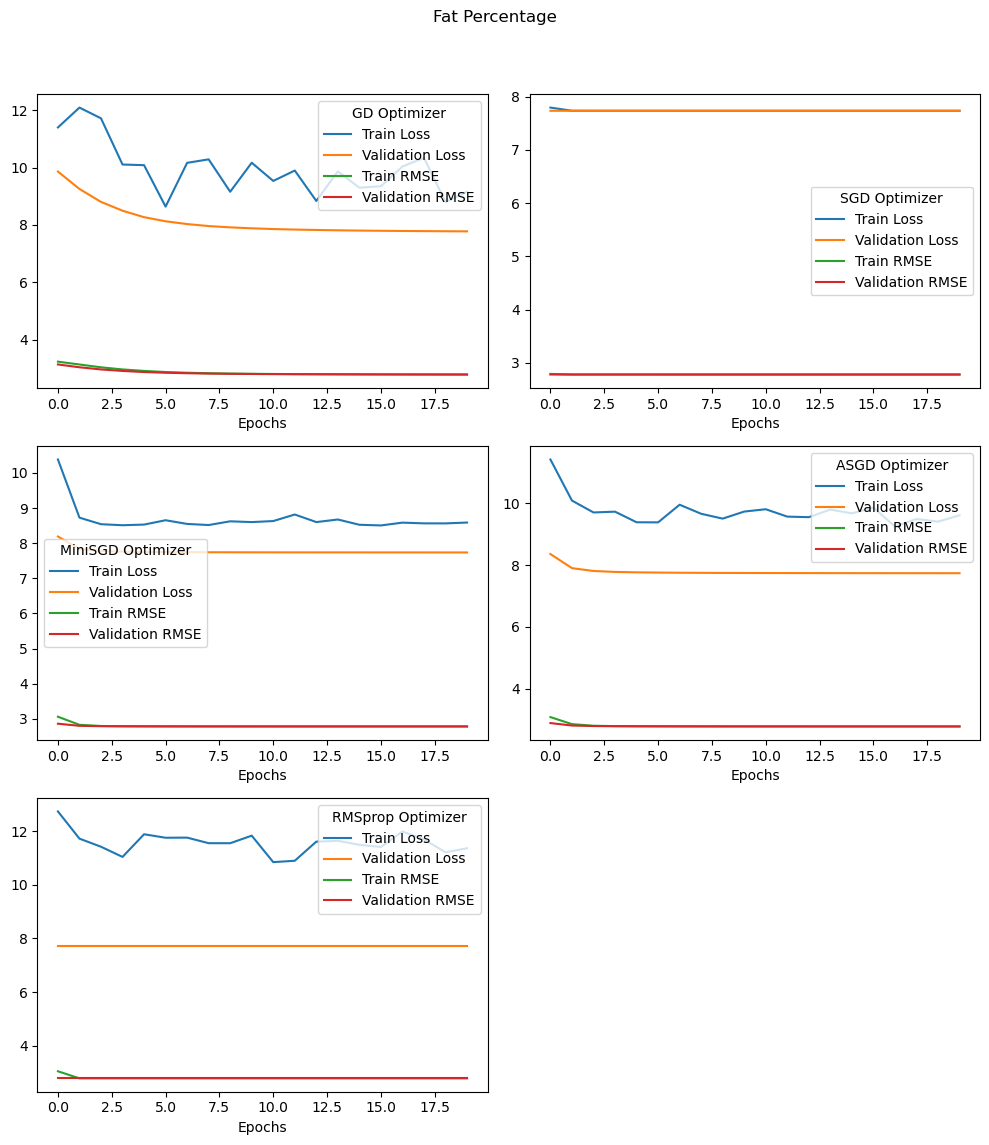

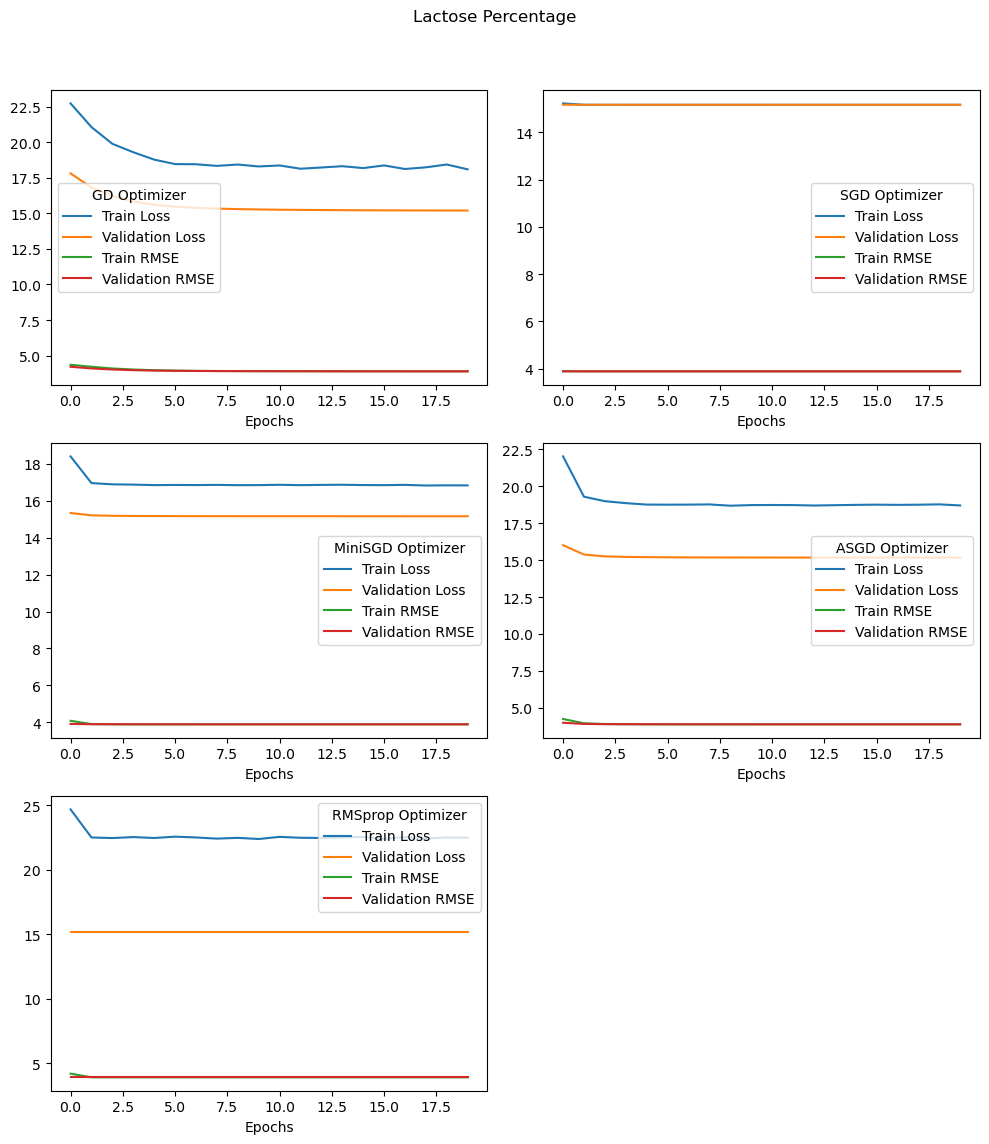

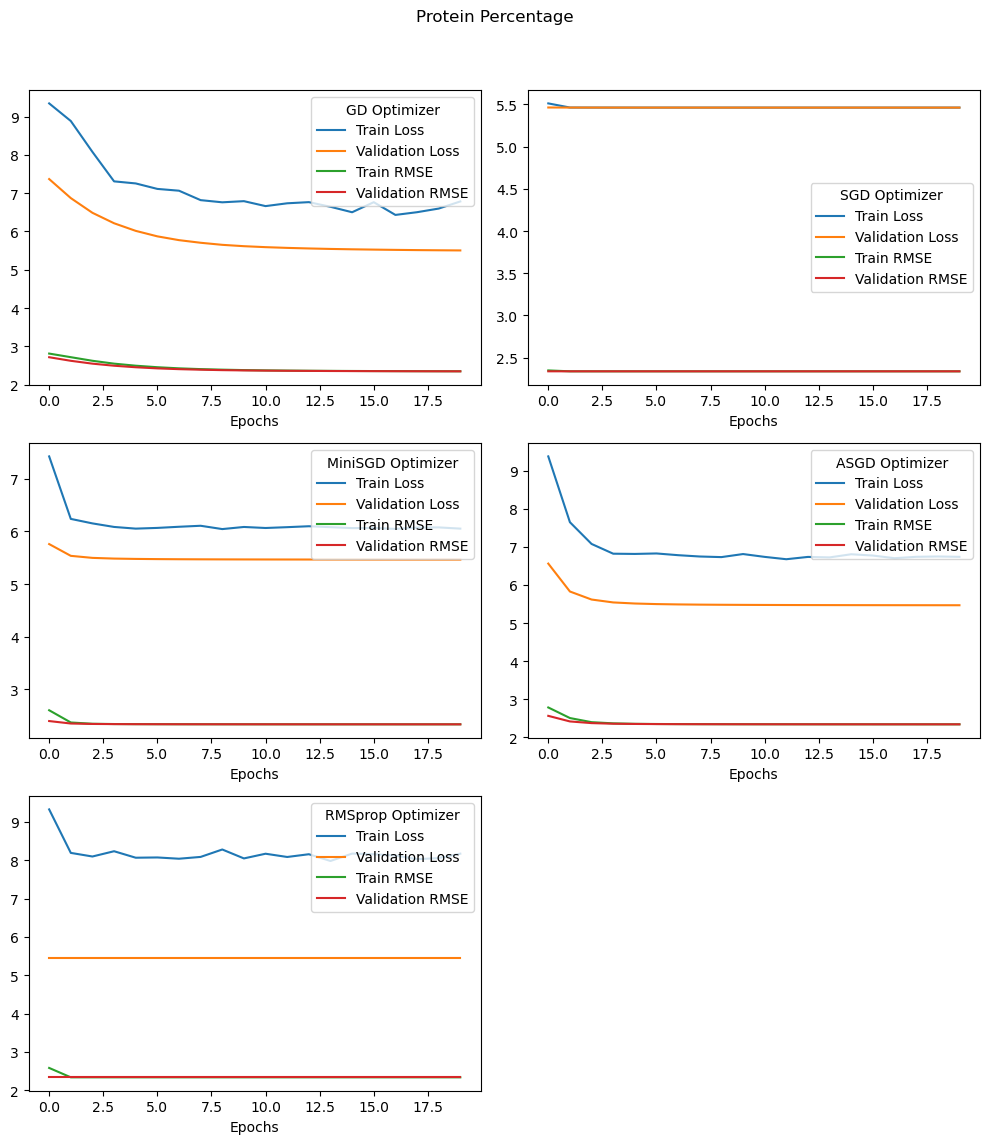

In [26]:
def plot_results(history, title):
    plt.figure(figsize=(10, 12))
    num_plots = len(history.keys())
    rows = 3
    cols = (num_plots + rows - 1) // rows
    
    for i, (nn_name, data) in enumerate(history.items(), 1):
        plt.subplot(rows, cols, i)
        plt.plot(data['metric_0'], label='Train Loss')
        plt.plot(data['metric_1'], label='Validation Loss')
        plt.plot(data['metric_2'], label='Train RMSE')
        plt.plot(data['metric_3'], label='Validation RMSE')
        plt.xlabel('Epochs')
        plt.legend(title=nn_name + ' Optimizer')
    
    plt.suptitle(title)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to fit the suptitle
    plt.show()

# Plot results for each target variable
plot_results(avg_history_fat, "Fat Percentage")
plot_results(avg_history_lactose, "Lactose Percentage")
plot_results(avg_history_protein, "Protein Percentage")


# NEAT

In [27]:
device = 'cpu'
temp_config_path = "temp_config_feedforward_xor"

def fitness_function(genomes, config, inputs, expected_outputs):
    inputs_list = inputs.tolist() if isinstance(inputs, torch.Tensor) else inputs
    outputs_list = expected_outputs.tolist() if isinstance(expected_outputs, torch.Tensor) else expected_outputs
    
    for genome_id, genome in genomes:
        net = neat.nn.FeedForwardNetwork.create(genome, config)
        genome.fitness = 0.0
        for xi, xo in zip(inputs_list, outputs_list):
            output = net.activate(xi)
            genome.fitness -= float((output[0] - xo) ** 2)

class StdOutReporter(neat.reporting.BaseReporter):
    def post_evaluate(self, config, population, species, best_genome):
        fit_mean = np.mean([g.fitness for g in population.values() if g.fitness is not None])
        fit_std = np.std([g.fitness for g in population.values() if g.fitness is not None])

        best_species_id = species.get_species_id(best_genome.key)
        best_fitness = float(best_genome.fitness)
        print('Population\'s average fitness: {0:3.5f} stdev: {1:3.5f}'.format(fit_mean, fit_std))
        print('Best fitness: {0:3.5f} - size: {1!r} - species {2} - id {3}'.format(best_fitness,
                                                                                     best_genome.size(),
                                                                                     best_species_id,
                                                                                     best_genome.key))

def run_neat_for_target(inputs, outputs, config, num_generations=15):
    pop = neat.Population(config)
    pop.add_reporter(neat.StdOutReporter(True))
    pop.add_reporter(StdOutReporter())
    stats = neat.StatisticsReporter()
    pop.add_reporter(stats)

    # Function to calculate fitness for each genome
    def eval_genomes(genomes, config):
        for genome_id, genome in genomes:
            net = neat.nn.FeedForwardNetwork.create(genome, config)
            genome.fitness = 0.0
            for xi, xo in zip(inputs, outputs):
                output = net.activate(xi)
                genome.fitness -= float((output[0] - xo) ** 2)

    # Run NEAT and collect fitness history
    fitness_history = []

    for gen in range(num_generations):
        pop.run(eval_genomes, 1)
        gen_fitnesses = [-genome.fitness for genome in pop.population.values() if genome.fitness is not None]
        gen_rmse = np.sqrt(np.mean(gen_fitnesses))
        fitness_history.append(gen_rmse)

    return fitness_history

# Load configuration file with UTF-8 encoding
config_path = "config-feedforward-xor"
temp_config_path = "temp_config_feedforward_xor"

# Read the configuration file with UTF-8 encoding, and handle errors
with open(config_path, 'r', encoding='utf-8', errors='replace') as f:
    content = f.read()

# Remove problematic characters
cleaned_content = ''.join(c for c in content if ord(c) < 128)

# Write cleaned content to a temporary file with UTF-8 encoding
with open(temp_config_path, 'w', encoding='utf-8') as f:
    f.write(cleaned_content)

# Load configuration using the temporary file
config = neat.config.Config(neat.DefaultGenome, neat.DefaultReproduction,
                            neat.DefaultSpeciesSet, neat.DefaultStagnation,
                            temp_config_path)

# Train NEAT models for each target
num_generations = 20
target_rmse = {
    'lactose': [[] for _ in range(num_generations)],
    'fat': [[] for _ in range(num_generations)],
    'protein': [[] for _ in range(num_generations)]
}

for fold_idx in range(len(X_train_kf)):
    X_train_fold = X_train_kf[fold_idx]
    y_fat_train_fold = y_fat_train_kf[fold_idx]
    y_lactose_train_fold = y_lactose_train_kf[fold_idx]
    y_protein_train_fold = y_protein_train_kf[fold_idx]

    # Convert data to numpy arrays
    X_train_fold_np = X_train_fold.cpu().numpy()
    y_fat_train_fold_np = y_fat_train_fold.cpu().numpy()
    y_lactose_train_fold_np = y_lactose_train_fold.cpu().numpy()
    y_protein_train_fold_np = y_protein_train_fold.cpu().numpy()
    
    # Run NEAT for each target
    lactose_rmse = run_neat_for_target(X_train_fold_np, y_lactose_train_fold_np, config, num_generations)
    fat_rmse = run_neat_for_target(X_train_fold_np, y_fat_train_fold_np, config, num_generations)
    protein_rmse = run_neat_for_target(X_train_fold_np, y_protein_train_fold_np, config, num_generations)
    
    for gen in range(num_generations):
        target_rmse['lactose'][gen].append(lactose_rmse[gen])
        target_rmse['fat'][gen].append(fat_rmse[gen])
        target_rmse['protein'][gen].append(protein_rmse[gen])

# Calculate average RMSE for each epoch across folds
average_rmse = {
    'lactose': [np.mean(rmses) for rmses in target_rmse['lactose']],
    'fat': [np.mean(rmses) for rmses in target_rmse['fat']],
    'protein': [np.mean(rmses) for rmses in target_rmse['protein']]
}


 ****** Running generation 0 ****** 

Population's average fitness: -6208.44113 stdev: 0.00000
Best fitness: -6208.44113 - size: (1, 0) - species 1 - id 1
Population's average fitness: -6208.44113 stdev: 0.00000
Best fitness: -6208.44113 - size: (1, 0) - species 1 - id 1
Average adjusted fitness: 0.000
Mean genetic distance 2.258, standard deviation 1.446
Population of 100 members in 2 species:
   ID   age  size   fitness   adj fit  stag
  ====  ===  ====  =========  =======  ====
     1    0    82  -6208.441    0.000     0
     2    0    18  -6208.441    0.000     0
Total extinctions: 0
Generation time: 0.068 sec

 ****** Running generation 1 ****** 

Population's average fitness: -6090.72109 stdev: 448.13185
Best fitness: -3945.84667 - size: (1, 1) - species 1 - id 177
Population's average fitness: -6090.72109 stdev: 448.13185
Best fitness: -3945.84667 - size: (1, 1) - species 1 - id 177
Average adjusted fitness: 0.032
Mean genetic distance 3.073, standard deviation 1.433
Population

/var/folders/rk/jdn7ny3s5pz59wz4cb1y33q40000gn/T/ipykernel_27402/745526104.py:42: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  genome.fitness -= float((output[0] - xo) ** 2)


Population's average fitness: -5538.91848 stdev: 910.50994
Best fitness: -3135.28783 - size: (1, 1) - species 3 - id 256
Population's average fitness: -5538.91848 stdev: 910.50994
Best fitness: -3135.28783 - size: (1, 1) - species 3 - id 256
Average adjusted fitness: 0.197
Mean genetic distance 3.278, standard deviation 1.437
Population of 100 members in 4 species:
   ID   age  size   fitness   adj fit  stag
  ====  ===  ====  =========  =======  ====
     1    2    56  -3860.231    0.223     0
     2    2    11  -3931.575    0.189     0
     3    1    25  -3135.288    0.255     0
     4    1     8  -5458.160    0.122     0
Total extinctions: 0
Generation time: 0.089 sec (0.077 average)

 ****** Running generation 3 ****** 

Population's average fitness: -4338.39264 stdev: 922.90463
Best fitness: -1979.51107 - size: (2, 4) - species 3 - id 366
Population's average fitness: -4338.39264 stdev: 922.90463
Best fitness: -1979.51107 - size: (2, 4) - species 3 - id 366
Average adjusted fitnes

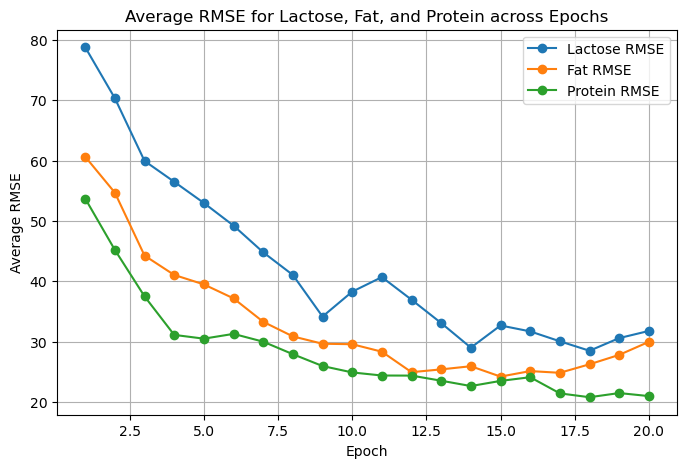

In [28]:
# Plot the RMSE values for each target
epochs = range(1, num_generations + 1)

plt.figure(figsize=(8, 5))
plt.plot(epochs, average_rmse['lactose'], label='Lactose RMSE', marker='o')
plt.plot(epochs, average_rmse['fat'], label='Fat RMSE', marker='o')
plt.plot(epochs, average_rmse['protein'], label='Protein RMSE', marker='o')

plt.xlabel('Epoch')
plt.ylabel('Average RMSE')
plt.title('Average RMSE for Lactose, Fat, and Protein across Epochs')
plt.legend()
plt.grid(True)
plt.show()

# GSGP

In [31]:
seed = 1
# device = 'cuda' if torch.cuda.is_available() else 'cpu'
device = 'mps' if torch.backends.mps.is_available() else 'cpu'
shuffle, p_test, p_val, n_batches_pct = True, .3, .3, 1

# Setup logging properties
file_dir = './log/'
file_name = 'intro_gsgp.log'
log_path = file_dir + file_name
path_rts = os.path.join(file_dir, 'reconstruct', 'rts')
path_init_pop = os.path.join(file_dir, 'reconstruct', 'init_pop')

if os.path.exists(file_dir + file_name):
    os.remove(file_dir + file_name)
if not os.path.exists(file_dir):
    os.makedirs(file_dir)

for path_i in [file_dir, path_init_pop, path_rts]:
    if not os.path.exists(path_i):
        os.makedirs(path_i)

print([log_path, path_rts, path_init_pop])

['./log/intro_gsgp.log', './log/reconstruct/rts', './log/reconstruct/init_pop']


In [35]:
for i in range(0, len(X_train_kf)):
    batch_size = len(X_train_kf[i])
    ds_train_kf = TensorDataset(X_train_kf[i], y_lactose_train_kf[i])
    ds_val_kf = TensorDataset(X_val_kf[i], y_lactose_val_kf[i])
    dl_train_1  =DataLoader(ds_train_kf, batch_size, shuffle)
    dl_val_1 = DataLoader(ds_val_kf, batch_size, shuffle)
    fset = [function_map['add'], function_map['sub'], function_map['mul'], function_map['div']]
    sspace_sml_gs = {
        'n_dims': X_train_kf[i].shape[1],
        'function_set': fset, 'constant_set': ERC(-1., 1.),
        'p_constants': 0.1,
        'max_init_depth': 3,
        'device': device,
        'n_batches': 1
    }
    pi_sml = SML(
    sspace=sspace_sml_gs,
    ffunction=Ffunctions('rmse'),
    dl_train=dl_train_1, dl_test=dl_val_1
)
    ps = batch_size
    selection_pressure = .07
    mutation_prob = .1
    xo_prob = .9
    seed = 1
    has_elitism = True
    allow_reproduction = False
    to, by = 5.0, 0.25
    ms = torch.arange(by, to + by, by, device=device)

    mheuristic = GeneticAlgorithm(
        pi=pi_sml,
        initializer=grow,
        selector=prm_tournament(pressure=selection_pressure),
        pop_size=ps,
        p_m=mutation_prob,
        p_c=xo_prob,
        elitism=has_elitism,
        reproduction=allow_reproduction,  # False = or xo or mutation
        device=device,
        seed=seed,
        #
        # Notice that, in GPOL-based implementation that we are using, 
        # these operators are the only settings that 
        # are necessary to define a Geometric Semantic GP.
        #
        crossover=prm_gs_xo(prm_grow(sspace=pi_sml.sspace), device=device),
        mutator=prm_gs_mtn(prm_grow(sspace=pi_sml.sspace), ms)
)
    mheuristic._initialize()
    print(mheuristic.pop)
    print('------------------------')
    print(mheuristic.best_sol.fit)
    print(mheuristic.best_sol.printTree())
    print('------------------------')

0)	[sub, mul, div, 12, tensor(-0.9433, device='mps:0'), 0, 7] (fit: tensor(4.3521, device='mps:0'))
1)	[add, add, 0, 13, sub, 17, 7] (fit: tensor(5.3418, device='mps:0'))
2)	[div, div, 9, 16, 6] (fit: tensor(31.6659, device='mps:0'))
3)	[mul, 16, 1] (fit: tensor(4.8943, device='mps:0'))
4)	[div, 5, 11] (fit: tensor(7.0189, device='mps:0'))
5)	[add, sub, 0, tensor(0.4068, device='mps:0'), 5] (fit: tensor(5.4877, device='mps:0'))
6)	[sub, 17, 11] (fit: tensor(5.1206, device='mps:0'))
7)	[mul, 19, div, 17, 1] (fit: tensor(4.8899, device='mps:0'))
8)	[div, div, 13, tensor(0.0802, device='mps:0'), 0] (fit: tensor(216.1346, device='mps:0'))
9)	[sub, sub, mul, 2, 14, mul, 19, 2, sub, 5, 9] (fit: tensor(5.1478, device='mps:0'))
10)	[div, 3, mul, 6, 16] (fit: tensor(48.2270, device='mps:0'))
11)	[sub, 0, add, 5, 13] (fit: tensor(5.1337, device='mps:0'))
12)	[sub, 0, 10] (fit: tensor(5.1658, device='mps:0'))
13)	[div, 6, 2] (fit: tensor(12.7073, device='mps:0'))
14)	[mul, div, 17, 6, 19] (fit: t

# Wilcoxon Signed-Rank Test

In [36]:
# Function to average RMSE values across optimizers
def average_rmse_across_optimizers(history):
    avg_rmse_train = []
    avg_rmse_valid = []
    for nn_name, folds_history in history.items():
        rmse_train_folds = []
        rmse_valid_folds = []
        for fold_name, metrics in folds_history.items():
            _, _, rmse_train, rmse_valid = metrics
            rmse_train_folds.append(rmse_train)
            rmse_valid_folds.append(rmse_valid)
        avg_rmse_train.append(np.mean(rmse_train_folds, axis=0))
        avg_rmse_valid.append(np.mean(rmse_valid_folds, axis=0))
    return np.mean(avg_rmse_train, axis=0), np.mean(avg_rmse_valid, axis=0)

# Average RMSE values across optimizers for each target
avg_rmse_train_fat, avg_rmse_valid_fat = average_rmse_across_optimizers(history_kfold_fat)
avg_rmse_train_lactose, avg_rmse_valid_lactose = average_rmse_across_optimizers(history_kfold_lactose)
avg_rmse_train_protein, avg_rmse_valid_protein = average_rmse_across_optimizers(history_kfold_protein)

# Use NEAT RMSE values (assuming they are precomputed)
neat_rmse_fat = average_rmse['fat']
neat_rmse_lactose = average_rmse['lactose']
neat_rmse_protein = average_rmse['protein']

# Perform Wilcoxon Signed-Rank Test
def perform_wilcoxon_test(avg_rmse_nn, neat_rmse, target_variable):
    # Ensure both lists have the same length for a valid test
    min_length = min(len(avg_rmse_nn), len(neat_rmse))
    avg_rmse_nn = avg_rmse_nn[:min_length]
    neat_rmse = neat_rmse[:min_length]
    
    stat, p_value = wilcoxon(avg_rmse_nn, neat_rmse)
    print(f"Wilcoxon test for {target_variable} RMSE: statistic={stat}, p-value={p_value}")

# Perform tests for each target variable
perform_wilcoxon_test(avg_rmse_valid_fat, neat_rmse_fat, "fat")
perform_wilcoxon_test(avg_rmse_valid_lactose, neat_rmse_lactose, "lactose")
perform_wilcoxon_test(avg_rmse_valid_protein, neat_rmse_protein, "protein")

Wilcoxon test for fat RMSE: statistic=0.0, p-value=1.9073486328125e-06
Wilcoxon test for lactose RMSE: statistic=0.0, p-value=1.9073486328125e-06
Wilcoxon test for protein RMSE: statistic=0.0, p-value=1.9073486328125e-06
